# Memory_rate

In [3]:
pip install chromedriver-binary==109.0.5414.74.0

  Preparing metadata (setup.py) ... done
  Created wheel for chromedriver-binary: filename=chromedriver_binary-109.0.5414.74.0-py3-none-any.whl size=8298456 sha256=4b05bcb8ac9b2ea97cdc9746348512d4ab2fbc5fb67e01a0c7e01f5601da98bb
  Stored in directory: /Users/hjm.f/Library/Caches/pip/wheels/76/12/7d/59a00325f84164e2e6aace9289886616da32e48fa2ffddc4a4
Successfully built chromedriver-binary
  Attempting uninstall: chromedriver-binary
    Found existing installation: chromedriver-binary 107.0.5304.62.0
    Uninstalling chromedriver-binary-107.0.5304.62.0:
      Successfully uninstalled chromedriver-binary-107.0.5304.62.0
Note: you may need to restart the kernel to use updated packages.


In [155]:
import sys

print("{}{: >25}{}{: >10}{}".format('|','Variable Name','|','Memory','|'))
print(" ------------------------------------ ")
for var_name in dir():
    if not var_name.startswith("_") and sys.getsizeof(eval(var_name)) > 10000: #ここだけアレンジ
        print("{}{: >25}{}{: >10}{}".format('|',var_name,'|',sys.getsizeof(eval(var_name)),'|'))

|            Variable Name|    Memory|
 ------------------------------------ 
|                       hb|   4268282|
|           pred_table_L_d|    574667|
|           pred_table_L_g|    628017|
|           pred_table_M_d|    645768|
|           pred_table_M_g|    645380|
|           pred_table_S_d|    417766|
|           pred_table_S_g|    670212|
|           pred_table_cos|   2153221|
|        pred_table_placex|   3335211|
|        pred_table_st_L_d|    447787|
|        pred_table_st_L_g|    232632|
|        pred_table_st_M_d|    232632|
|        pred_table_st_M_g|    558272|
|        pred_table_st_S_d|    290782|
|        pred_table_st_S_g|    372192|
|          pred_table_st_d|    969801|
|          pred_table_st_g|   1161432|
|           pred_table_stx|   2157625|
|                  predx_1|     26823|
|                  predx_2|     26823|
|                   tansho|   4073580|


In [1]:
del jockey_results

NameError: name 'jockey_results' is not defined

|過去レースデータ(訓練データ)|加工内容|出馬表データ|
|:--:|:--:|:--:|
|r.data||st.data|
|↓<br> r.preprocessing()<br>↓|前処理<br>|↓<br>st.preprocessing()<br>↓|
|r.data_p||st.data_p|
|↓<br>r.merge_horse_results(hr)<br>↓|馬の過去成績データ追加<br>|↓<br>st.merge_horse_results(hr)<br>↓|
|r.data_h||st.data_h|
|↓<br>r.merge_jrs()<br>↓|騎手データ追加<br>|↓<br>st.merge_jrs()<br>↓|
|r.data_j||st.data_j|
|↓<br>r.merge_peds()<br>↓|血統データ追加<br>|↓<br>st.merge_peds()<br>↓|
|r.data_pe||st.data_pe|
|↓<br>r.process_categorical()<br>↓|カテゴリ変数処置<br>|↓<br>st.process_categorical()<br>↓|
|r.data_c||st.data_c|

# Import

In [1]:
import numpy as np
import pandas as pd
import re
import statistics
import math
from math import sqrt

import datetime
import time
from tqdm.notebook import tqdm

import scipy as sp
from scipy.special import comb
from scipy.optimize import curve_fit
from scipy.stats import norm
from scipy.stats import gaussian_kde
from scipy.integrate import cumtrapz
from scipy import optimize

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
from selenium.webdriver import Chrome, ChromeOptions
import chromedriver_binary

import optuna
import optuna.integration.lightgbm as lgb_o
import lightgbm as lgb
from lightgbm import LGBMClassifier

from tensorflow import keras
from keras import models
from keras import layers
import pickle5 as pickle

import pyarrow as pa
import pyarrow.parquet
import pyarrow.csv


from itertools import combinations
from itertools import permutations
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

# Code

In [2]:
class DataProcessor:
    def __init__(self):
        self.data = pd.DataFrame() #raw data
        self.data_p = pd.DataFrame() #after preprocessing
        self.data_c = pd.DataFrame() #after processing categorical features
        #self.data_num_rate = pd.DataFrame()
        
    def merge_horse_results(self, hr, n_samples_list=[1,2,3,4,5,6]):
        self.data_p = self.data_p.copy()
        for n_samples in n_samples_list:
            self.data_p = hr.merge_all(self.data_p, n_samples=n_samples)
        
        self.data_p['interval'] = (self.data_p['date'] - self.data_p['latest']).dt.days
        self.data_p['interval'] = self.data_p['interval'].map(lambda x: math.log(x) if x>0 else 0)
        self.data_p.drop(['latest'], axis=1, inplace=True)

    def merge_jockey_results(self, jr, n_samples_list=[60,180]):
        self.data_p = self.data_p.copy()
        for n_samples in n_samples_list:
            self.data_p = jr.merge_all(self.data_p, n_samples=n_samples)
        #self.data_j.drop(['place'], axis=1, inplace=True)
        
    def merge_trainer_results(self, tr, n_samples_list=[180]):
        self.data_p = self.data_p.copy()
        for n_samples in n_samples_list:
            self.data_p = tr.merge_all(self.data_p, n_samples=n_samples)
    
    def process_categorical(self, results_m,st=False):
        df = self.data_p.copy()
        df.drop(['horse_id','jockey_id','trainer_id'], axis=1, inplace=True)

        R_types = results_m['R_type'].unique()
        df['R_type'] = pd.Categorical(df['R_type'], R_types)
        df = pd.get_dummies(df, columns=['R_type'])
        
        df['weather'] = df['weather'].map(weather_dict).fillna('0').astype(int)
        df['sex'] = df['sex'].map(sex_dict).fillna('0').astype(int)
        
        df['spurt_2'] = 2*df['spurt_2R'] - df['spurt_1R']
        df['speed_2'] = 2*df['speed_2R'] - df['speed_1R']
        df['diff_2'] = 2*df['diff_2R'] - df['diff_1R']
        df['runtime_2'] = 2*df['runtime_2R'] - df['runtime_1R']
        df['h_rank/heads_2'] = 2*df['h_rank/heads_2R'] - df['h_rank/heads_1R']
        df['h_rank/heads*grade_2'] = 2*df['h_rank/heads*grade_2R'] - df['h_rank/heads*grade_1R']
        
        df['spurt_3'] = 3*df['spurt_3R'] - df['spurt_1R'] - df['spurt_2']
        df['speed_3'] = 3*df['speed_3R'] - df['speed_1R'] - df['speed_2']
        df['diff_3'] = 3*df['diff_3R'] - df['diff_1R'] - df['diff_2']
        df['runtime_3'] = 3*df['runtime_3R'] - df['runtime_1R'] - df['runtime_2']
        df['h_rank/heads_3'] = 3*df['h_rank/heads_3R'] - df['h_rank/heads_1R'] - df['h_rank/heads_2']
        df['h_rank/heads*grade_3'] = 3*df['h_rank/heads*grade_3R'] - df['h_rank/heads*grade_1R']-df['h_rank/heads*grade_2']
        
        df['course_gap'] = df['course_len']-df['course_len_mean']
        df['R_class'] = df['No.1_sum'].groupby(level=0).mean()
        df['horse_prize_mean'] = df['prize_sum'].groupby(level=0).mean()
        df['prize_gap'] = df['prize_sum'] - df['horse_prize_mean']
        df['class_gap'] = df['No.1_sum'] - df['R_class']
        
        def scale(x):
            res = (x - np.mean(x)) / np.std(x, ddof=1)
            return res
        df['No.1/days'] = (df['No.1_sum']/df['days'])
        df['No.3/days'] = (df['No.3_sum']/df['days'])
        df['prize/days'] = (df['prize_sum']/df['days'])
        df['jw_rate_60R'] = df['jw_rate_60R'].map(lambda x: math.log(x) if x>0 else 0)
        df['jp_rate_60R'] = df['jp_rate_60R'].map(lambda x: math.log(x) if x>0 else 0)
        #df['tw_rate_60R'] = df['tw_rate_60R'].map(lambda x: math.log(x) if x>0 else 0)
        #df['tp_rate_60R'] = df['tp_rate_60R'].map(lambda x: math.log(x) if x>0 else 0)
        df['place'] = df['place'].astype(int)
        
        def growth_1(x):
            z = 0.004506*x*x*x - 0.1219*x*x + 1.005*x - 1.877
            return z
        def growth_0(x):
            z = 0.009971*x*x*x - 0.2207*x*x + 1.567*x - 2.984
            return z
        def growth_rate_1(x):
            z = 0.013518*x*x - 0.2438*x + 1.005
            return z
        def growth_rate_0(x):
            z = 0.029913*x*x - 0.4414*x + 1.567
            return z

        df1 = df[df['sex']== -1]
        df0 = df[df['sex']!= -1]

        df1['growth'] = growth_1(df1['days'])
        df0['growth'] = growth_0(df0['days'])
        df1['growth_rate'] = growth_rate_1(df1['days'])
        df0['growth_rate'] = growth_rate_0(df0['days'])

        df = pd.concat([df1,df0])
        df = df.loc[:,~df.columns.duplicated()]
        def style_judge(x):
                if x<3: 
                    return 0
                if x>=3:
                    if x<6:
                        return 1
                    if x>=6:
                        if x<9:
                            return 2
                        if x>=9:
                            if x<12:
                                return 3
                            if x>=12:
                                if x<15:
                                    return 4
                                if x>=15:
                                    return 5
                            
        if st==False:
            swr = df[['R_type_芝','place','course_len','1st_corner_3R','rank<3','単勝']].copy()
            
            swr['style'] = swr['1st_corner_3R'].map(lambda x : style_judge(x))
            wins = swr[swr['rank<3']==1]
            swr_count = swr.groupby(['R_type_芝','place','course_len','style'])
            wins_count = wins.groupby(['R_type_芝','place','course_len','style'])
            df_swr = wins_count.count()/swr_count.count()

            df_swr['style_winrate'] = df_swr['単勝']#単勝じゃなくてもいい
            df['style'] = df['1st_corner_3R'].map(lambda x : style_judge(x))
            df = df.join(df_swr['style_winrate'],on=['R_type_芝','place','course_len','style'])
            del swr, wins, swr_count, wins_count,
            df_swr.to_pickle('running_style_winrate.pickle')
        
        if st==True:
            df['style'] = df['1st_corner_3R'].map(lambda x : style_judge(x))
            df_swr = pd.read_pickle('running_style_winrate.pickle')
            df = df.join(df_swr['style_winrate'],on=['R_type_芝','place','course_len','style'])
            
            
        
        self.data_c = df
        
class ShutubaTable(DataProcessor):
    def __init__(self,shutuba_tables):
        super(ShutubaTable,self).__init__()
        self.data = shutuba_tables
    @classmethod
    def scrape(cls,race_id_list):
        data = pd.DataFrame()
        for race_id in tqdm(race_id_list):
            url = 'https://race.netkeiba.com/race/shutuba.html?race_id=' + race_id
            df = pd.read_html(url)[0]
            df = df.T.reset_index(level=0,drop=True).T
            
            html = requests.get(url)
            html.encoding = 'EUC-JP'
            soup = BeautifulSoup(html.text,'html.parser')
            
            texts = soup.find('div',attrs={'class':'RaceData01'}).text
            texts = re.findall(r'\w+',texts)
            for text in texts:
                if 'm' in text:
                    df['course_len'] = [int(re.findall(r'\d+',text)[0])] * len(df)
                if text in ['曇','晴','雨','小雨','小雪','雪']:
                    df['weather'] = [text] * len(df)
                if text in ['良', '稍重', '重']:
                    df['ground_state'] = [text] * len(df)
                if '不' in text:
                    df['ground_state'] = ['不良'] * len(df)
                if '稍' in text:
                    df['ground_state'] = ['稍重'] * len(df)
                if '芝' in text:
                    df['R_type'] = ['芝'] * len(df)
                if '障' in text:
                    df['R_type'] = ['障害'] * len(df)
                if 'ダ' in text:
                    df['R_type'] = ['ダート'] * len(df)
            

            #df['date'] = [date] * len(df)
            
            horse_id_list = []
            horse_td_list = soup.find_all('td',attrs={'class':'HorseInfo'})
            for td in horse_td_list:
                horse_id = re.findall(r'\d+',td.find('a')['href'])[0]
                horse_id_list.append(horse_id)
            
            jockey_id_list = []
            jockey_td_list = soup.find_all('td',attrs={'class':'Jockey'})
            for td in jockey_td_list:
                jockey_id = re.findall(r'\d+',td.find('a')['href'])[0]
                jockey_id_list.append(jockey_id)

            trainer_id_list = []
            trainer_td_list = soup.find_all('td',attrs={'class':'Trainer'})
            for td in trainer_td_list:
                trainer_id = re.findall(r'\d+',td.find('a')['href'])[0]
                trainer_id_list.append(trainer_id)
            

            df["horse_id"] = horse_id_list
            df['jockey_id'] = jockey_id_list
            df["trainer_id"] = trainer_id_list
            
            df.index = [race_id]*len(df)
            date = soup.find('dd',attrs={'class':'Active'}).text
            df['date'] = df.index.str[:4] + '-'+re.findall(r'\w+',date)[0].replace('月','-').replace('日','')
            #df['date'] = re.findall(r'\d+/\d+',date)[0]
            #df['date'] = df.index.str[:4] +'/'+ df['date']
            data = data.append(df)
            time.sleep(0.1)
            
        return cls(data)
    
    def preprocessing(self,weight=False):
        df = self.data.copy()
        #df['R'] = df.index.str[-2:].astype(int)
        
        df['sex'] = df['性齢'].map(lambda x: str(x)[0])
        #df['age'] = df['性齢'].map(lambda x: str(x)[1:]).astype(int)
        df['R'] = df.index.str[-2:].astype(int)
        
        #df.drop(['馬体重(増減)'], axis=1, inplace=True)
        df['jockey_weight'] = df['斤量'].astype(float)
        #1/4馬体重を考慮する
        if weight:
            df = df[df['馬体重(増減)'] != '--']
            df['weight'] = df['馬体重(増減)'].str.split('(', expand=True)[0].astype(float)
            df['++weight'] = df['馬体重(増減)'].str.split('(', expand=True)[1].str[:-1].replace('前計不',0).astype(float)
            df['weight_per'] = df['jockey_weight']/df['weight']
        
        df['date'] = pd.to_datetime(df['date'])
        df['waku'] = df['枠'].astype(int)
        df['number'] = df['馬番'].astype(int)
        df['course_len'] = df['course_len'].astype(float)
        df['place'] = df['開催'] = df.index.map(lambda x: str(x)[4:6]).astype(int)
        df['n_horses'] = df.index.map(df.index.value_counts())
        df['month'] = df['date'].dt.month
        df['weather'] = df['weather'].map(weather_dict).fillna('0').astype(int)
        df['sex'] = df['sex'].map(sex_dict).fillna('0').astype(int)
        df['ground'] = df['ground_state'].str.extract(r'(\D+)')[0].map(ground_dict).fillna('5')
        df['ground'] = df['ground'].astype(int)
        df = df[df['ground']!=5]
        df.drop(['ground_state'], axis=1, inplace=True) 
        df['m/kg'] = df['course_len'] /df['jockey_weight']
        
        if weight==False:
            df = df[['course_len','m/kg','date','R','number','waku','jockey_weight','place','month','n_horses','weather','R_type','ground','horse_id','jockey_id','trainer_id','sex',]]
        
        #2/4馬体重を考慮する
        if weight:
            df = df[['course_len','m/kg','date','R','weight','++weight','number','waku','jockey_weight','weight_per','place','month','n_horses','weather','R_type','ground','horse_id','jockey_id','trainer_id','sex',]]
        
        self.data_p = df
        waku_winrate = pd.read_pickle('waku_winrate.pickle')
        df_join = df.join(waku_winrate['waku_winrate'],on=['place','R_type','course_len','waku'])
        #df_join = df.join(r.data_num_rate['waku_winrate'],on=['place','R_type','course_len','waku'])
        self.data_p = df_join
        
        self.data_p = pd.merge(self.data_p,hb,left_on='horse_id',right_index=True)
        self.data_p['days'] = (self.data_p['date']-self.data_p['birth']).dt.days/365
        
        course_infos = pd.read_excel('course_infos.xlsx')
        self.data_p_merge = self.data_p.merge(course_infos,on=['place','R_type','course_len'],how='left')
        self.data_p_merge.index=self.data_p.index
        self.data_p_merge['last_slope'] = self.data_p_merge['last_ΔH']/self.data_p_merge['last_ΔL']*100
        self.data_p_merge['first_slope'] = self.data_p_merge['first_ΔH']/self.data_p_merge['first_ΔL']*100
        self.data_p = self.data_p_merge.copy()
        
        
        del df_join,self.data_p_merge
                
class Results(DataProcessor):
    def __init__(self,results):
        super(Results,self).__init__()
        self.data = results
    
    @classmethod
    def read_pickle(cls, path_list):
        df = pd.concat([pd.read_pickle(path) for path in path_list])
        return cls(df)
        
    def preprocessing(self, year, R, weight=False):
        df = self.data.copy()
        
        df['R'] = df.index.str[-2:].astype(int)
        df['着順'] = pd.to_numeric(df['着順'],errors='coerce')
        df.dropna(subset=['着順'],inplace=True)
        df['着順'] = df['着順'].astype(int)
        df['rank=1'] = df['着順'].map(lambda x:1 if  x==1 else 0)
        df['rank<2'] = df['着順'].map(lambda x:1 if  x<3 else 0)
        df['rank<3'] = df['着順'].map(lambda x:1 if  x<4 else 0)
        df['rank<5'] = df['着順'].map(lambda x:1 if  x<6 else 0)
        df['rank<8'] = df['着順'].map(lambda x:1 if  x<9 else 0)
        df['sex'] = df['性齢'].map(lambda x: str(x)[0])        
        df['number'] = df['馬番'].astype(int)
        df['waku'] = df['枠番'].astype(int)
        df['jockey_weight'] = df['斤量'].astype(int)
        df['R_type'] = df['race_type']
        
        #3/4馬体重を考慮する
        if weight:
            df['weight'] = df['馬体重'].str.split("(", expand=True)[0].astype(float)
            df['++weight'] = df['馬体重'].str.split("(", expand=True)[1].str[:-1].astype(float)
            df['weight_per'] = df['jockey_weight']/df['weight']
        
        df['単勝'] = df['単勝'].astype(float)
        df['course_len'] = df['course_len'].map(lambda x: 2000.0 if x<3 else x)
        df['course_len'] = df['course_len'].astype(float)
        df['m/kg'] = df['course_len'] /df['jockey_weight']
        df['place'] = df.index.map(lambda x: str(x)[4:6]).astype(int)
        df['date'] = pd.to_datetime(df['date'], format="%Y年%m月%d日")
        df['month'] = df['date'].dt.month
        df['n_horses'] = df.index.map(df.index.value_counts())
        df['ground'] = df['ground_state'].str.extract(r'(\D+)')[0].map(ground_dict).fillna('5')
        df['ground'] = df['ground'].astype(int)
        df = df[df['ground']!=5]
        
        ###除外対象
        df = df[df['jockey_id']!='00815']
        df = df[df['jockey_id']!='05074']
        df = df[df['jockey_id']!='05455']
        df = df[df['jockey_id']!='05396']
        df = df[df['jockey_id']!='05294']
        df = df[df['jockey_id']!='05490']
        df = df[df['trainer_id']!='05235']
        df = df[df['trainer_id']!='05390']
        df = df[df['trainer_id']!='05160']
        df = df[df['trainer_id']!='05681']
        ###
        
        df.drop(['枠番','馬番','斤量','タイム', '着差', '調教師', '性齢','馬名','騎手','馬体重', '人気','owner_id','ground_state','race_type'], axis=1, inplace=True)
        
        self.data_p = df
        self.data_p_rank = df[df['rank<3']==1]
        self.data_p_ = self.data_p[['place','course_len','R_type','着順','waku']]
        self.data_p_rank = self.data_p_rank[['place','course_len','R_type','着順','waku']]
        self.data_p_grp = self.data_p_.groupby(['place','R_type','course_len','waku'])
        self.data_p_rank_grp = self.data_p_rank.groupby(['place','R_type','course_len','waku'])
        self.data_num_rate = self.data_p_rank_grp.count()/self.data_p_grp.count()
        self.data_num_rate['waku_winrate'] = self.data_num_rate['着順'].map(lambda x: 0.5 if x>0.5 else x)
        self.data_num_rate.to_pickle('waku_winrate.pickle')
        waku_winrate = pd.read_pickle('waku_winrate.pickle')
        df_join = df.join(waku_winrate['waku_winrate'],on=['place','R_type','course_len','waku'])
        
        df_join.drop(['着順'], axis=1, inplace=True)
        self.data_p = df_join
        self.data_p['date'] = pd.to_datetime(self.data_p['date'], format="%Y年%m月%d日")
        self.data_p = self.data_p[self.data_p['R_type']!='障害']
        self.data_p = pd.merge(self.data_p,hb,left_on='horse_id',right_index=True)
        self.data_p['days'] = (self.data_p['date']-self.data_p['birth']).dt.days/365
        self.data_p = self.data_p[self.data_p['R'] > R]
        self.data_p = self.data_p[self.data_p['date'] > year]
        
        course_infos = pd.read_excel('course_infos.xlsx')
        self.data_p_merge = self.data_p.merge(course_infos,on=['place','R_type','course_len'],how='left')
        self.data_p_merge.index=self.data_p.index
        self.data_p_merge['last_slope'] = self.data_p_merge['last_ΔH']/self.data_p_merge['last_ΔL']*100
        self.data_p_merge['first_slope'] = self.data_p_merge['first_ΔH']/self.data_p_merge['first_ΔL']*100
        self.data_p = self.data_p_merge.copy()
        
        del df_join, self.data_p_, self.data_p_rank, self.data_p_rank_grp, self.data_p_grp,self.data_p_merge

    def process_categorical(self):
        #self.le_horse = LabelEncoder().fit(self.data_p['horse_id'])
        #self.le_jockey = LabelEncoder().fit(self.data_p['jockey_id'])
        #self.le_trainer = LabelEncoder().fit(self.data_p['trainer_id'])
        #super().process_categorical(self.le_horse,self.le_jockey,self.le_trainer,self.data_p)
        super().process_categorical(self.data_p)

class HorseResults:
    def __init__(self, horse_results):
        self.horse_results = horse_results[['日付','開催','R','レース名','頭数','オッズ','着順','斤量','距離','馬場','馬場指数','タイム','着差','ﾀｲﾑ指数','通過','ペース','上り','賞金','備考','x','y',]]#'人気',
        self.preprocessing()
        
    @classmethod
    def read_pickle(cls, path_list):
        df = pd.concat([pd.read_pickle(path) for path in path_list])
        return cls(df)

    def preprocessing(self):
        df = self.horse_results.copy()
        df = df.loc[:,~df.columns.duplicated()]
        df.index.name = 'horse_id'
        
        def scale(x):
            res = (x - np.mean(x)) / np.std(x, ddof=1)
            return res

        def Deviation_val(x):
            val = ((x - x.mean())/x.std())*1+10
            return val
        
        #コーナーへの進入順位をintに変換
        def corner(x,n):
            if type(x) != str:
                return x
            elif n==4:
                return int(re.findall(r'\d+', x)[-1])
            elif n==1:
                return int(re.findall(r'\d+', x)[0])

        def www(x,n):
            return int(re.findall(r'\d+', x)[0])

        #R_grade
        df1 = df['レース名']
        df0 = df1.astype(str).map(lambda x: 1.00 if '新馬' in x else x )
        df1 = df0.astype(str).map(lambda x: 1.00 if '未勝利' in x else x )
        df0 = df1.astype(str).map(lambda x: 0.97 if '500万下' in x else x )
        df1 = df0.astype(str).map(lambda x: 0.88 if '1000万下' in x else x )
        df0 = df1.astype(str).map(lambda x: 0.53 if '1600万下' in x else x )
        df1 = df0.astype(str).map(lambda x: 0.97 if '1勝クラス' in x else x )
        df0 = df1.astype(str).map(lambda x: 0.88 if '2勝クラス' in x else x )
        df1 = df0.astype(str).map(lambda x: 0.53 if '3勝クラス' in x else x )
        df0 = df1.astype(str).map(lambda x: 0.36 if 'OP' in x else x )
        df1 = df0.astype(str).map(lambda x: 0.30 if 'L' in x else x )
        df0 = df1.astype(str).map(lambda x: 0.23 if 'G3' in x else x )
        df1 = df0.astype(str).map(lambda x: 0.12 if 'G2' in x else x )
        df0 = df1.astype(str).map(lambda x: 0.08 if 'G1' in x else x )
        df1 = df0.astype(str).map(lambda x: 0.30 if 'G' in x else x )
        df['R_grade'] = pd.to_numeric(df1, errors='coerce')
        df.dropna(subset=['R_grade'], inplace=True)
        df['R_grade'] = 1/df['R_grade']
        
        #cols_to_numeric = ['頭数','馬場指数','着順','距離','','',]

        #place
        df['place'] = df['開催'].str.extract(r'(\D+)')[0].map(place_dict).fillna('11')
        df['place'] = df['place'].astype(int)
        df = df[df['place']!=11]

        #R_type[芝orダor障]を作成し、[障]を除外
        df['R_type'] = df['距離'].str.extract(r'(\D+)')[0].map(R_type_dict)

        #date
        df["date"] = pd.to_datetime(df["日付"])
        df.drop(['日付'], axis=1, inplace=True)

        #R
        df['R'] = df['R']
        df.dropna(subset=['R'], inplace=True)

        #heads
        df['頭数'] = pd.to_numeric(df['頭数'], errors='coerce')
        df.dropna(subset=['頭数'], inplace=True)
        df['heads'] = df['頭数'].astype(int)

        #ground
        df['馬場指数'] = pd.to_numeric(df['馬場指数'], errors='coerce')
        df.dropna(subset=['馬場指数'], inplace=True)#subsetでdrop対象の列を指定
        df['ground'] = df['馬場指数'].astype(float)

        #course_len
        df['距離'] = df['距離'].map(lambda x: www(x,1))
        df['距離'] = pd.to_numeric(df['距離'], errors='coerce')
        df.dropna(subset=['距離'], inplace=True)
        df['course_len'] = df['距離'].astype(int)

        #kg
        df.dropna(subset=['斤量'], inplace=True)
        df['kg'] = df['斤量']

        #course_len * kg
        df['len*kg'] = df['course_len']*df['kg']/10

        #h_rank
        df['着順'] = pd.to_numeric(df['着順'], errors='coerce')
        df.dropna(subset=['着順'], inplace=True)#subsetでdrop対象の列を指定
        df['h_rank'] = df['着順'].astype(int)

        #No.1 No.3 n_entry
        df['No.1'] = df['h_rank'].map(lambda x: 1 if x<2 else 0)
        df['No.3'] = df['h_rank'].map(lambda x: 1 if x<4 else 0)
        df['n_entry'] = df['h_rank'].map(lambda x: 1 if x<20 else 0)

        #1st_3F
        df['1st_3F'] = df['ペース'].str.split('-', expand=True)[0].astype(float)
        df['1st_3F'] = df['1st_3F'].map(lambda x:x if x>1 else 35)
        df['1st_3F'] = 600/df['1st_3F']
        df['1st_3F'] = df.groupby(['place','R_type','course_len','馬場'])['1st_3F'].transform(scale)

        #last_3F
        df['last_3F'] = df['ペース'].str.split('-', expand=True)[1].astype(float)
        df['last_3F'] = 600/df['last_3F']


        df['pace'] =  df['last_3F']/df['1st_3F']
        df['pace'] = df.groupby(['place','R_type','course_len','馬場'])['pace'].transform(scale)

        df['h_rank/heads'] = df['heads']/df['h_rank']
        df['h_rank/heads*grade'] = df['h_rank/heads']*df['R_grade']

        #rank / kg
        df['rank/kg'] = df['kg']/df['h_rank/heads']

        df['1st_corner'] = df['通過'].map(lambda x: corner(x,1))
        df['last_corner'] = df['通過'].map(lambda x: corner(x,4))
        df['1st-rank']  = df['1st_corner']  - df['h_rank']
        df['last-rank'] = df['last_corner'] - df['h_rank']
        df['1st-last']  = df['last_corner'] - df['1st_corner']

        #prize
        df['賞金'].fillna(0, inplace=True)
        df['prize'] = df['賞金'].map(lambda x: math.log10(x) if x>0 else 0)

        #diff
        df['着差'] = pd.to_numeric(df['着差'], errors='coerce')
        df.dropna(subset=['着差'], inplace=True)
        df['diff'] = df['着差']

        df['position_4C'] = df['y']*-2.4
        df['position_Goal'] = df['diff']*df['last_3F']
        df['rush'] = df['position_4C'] - df['position_Goal']

        df['last_3F'] = df.groupby(['place','R_type','course_len','馬場'])['last_3F'].transform(scale)
        df['diff'] = df.groupby(['place','R_type','course_len','馬場'])['diff'].transform(scale)*-1

        #ozz
        #df['オッズ'] = pd.to_numeric(df['オッズ'], errors='coerce')
        #df.dropna(subset=['上り'], inplace=True)
        #df = df[df['オッズ']!=0]
        #df['ozz'] = df['オッズ'].astype(float)
        #df['ozz'] = (1/df['ozz']).map(lambda x: math.log10(x) if x>0 else 0)
        #df['ozz'] = (df['ozz'] - df['ozz'].min())/(df['ozz'].max()-df['ozz'].min())

        #spurt
        df['上り'] = pd.to_numeric(df['上り'], errors='coerce')
        df.dropna(subset=['上り'], inplace=True)
        df['spurt'] = df['上り'].astype(float)
        df['spurt'] = 600/df['spurt']
        df['spurt'] = df['spurt'].map(lambda x: 13 if x<13 else x)
        df['spurt']  = df.groupby(['place','R_type','course_len','馬場'])['spurt'].transform(scale)

        #speed
        time = df['タイム']
        time = time.str.split(':', expand=True)
        for n in range(0,2):
            time[n] = pd.to_numeric(time[n], errors='coerce')
        df['time'] = time[0]*60 + time[1]
        df['speed'] = df['course_len']/df['time']
        df['speed'] = df['speed'].map(lambda x: 15 if x<15 else x)
        df['speed']  = df.groupby(['place','R_type','course_len','馬場'])['speed'].transform(scale)

        #runtime
        df['ﾀｲﾑ指数'] = pd.to_numeric(df['ﾀｲﾑ指数'], errors='coerce')
        df.dropna(subset=['ﾀｲﾑ指数'], inplace=True)#subsetでdrop対象の列を指定
        df['runtime'] = df['ﾀｲﾑ指数'].astype(float)
        df['runtime'] = df['runtime'].map(lambda x: 0 if x<0 else x)

        #R_level
        df['R_level'] = df['runtime']
        gr = df.groupby(['date','place','R'])['R_level'].quantile(0.25)
        df.drop(['R_level'], axis=1, inplace=True)
        df = df.merge(gr, left_on=['date','place','R'], right_index=True, how='left')
        del gr
        #df['R_level'] = (df['R_level'] - df['R_level'].min())/(df['R_level'].max()-df['R_level'].min())+0.05

        #R_level/rank
        df['rank/level'] = df['R_level']*df['h_rank/heads']

        df['late'] = df['備考'].astype(str).map(lambda x: 1 if '出遅れ' in x else 0 )

        cols_single = ['R_grade','ground','kg','len*kg','1st_3F','last_3F','pace','prize','diff','spurt','time','speed','runtime','R_level','rank/level','rank/kg','h_rank/heads*grade','position_4C','rush']#'ozz',
        for col in cols_single:
            df[col] = Deviation_val(df[col])

        df['speed*1st_3F'] = (df['speed']*df['1st_3F'])**0.5
        df['speed*last_3F'] = (df['speed']*df['last_3F'])**0.5
        df['speed*pace'] = (df['speed']*df['pace'])**0.5
        df['spurt*1st_3F'] = (df['spurt']/df['1st_3F'])
        df['spurt*last_3F'] = (df['spurt']/df['last_3F'])
        df['spurt*pace'] = (df['spurt']*df['pace'])**0.5
        df['spurt_Lv1'] = (df['spurt']-df['1st_3F'])
        df['spurt_Lv2'] = (df['spurt'] -df['last_3F'])
        df['diff*level'] = (df['diff']*df['R_level'])**0.5
        df['spurt*level'] = (df['spurt']*df['R_level'])**0.5
        df['speed*level'] = (df['speed']*df['R_level'])**0.5
        df['runtime*level'] = (df['runtime']*df['R_level'])**0.5
        df['diff*kg'] = (df['diff']*df['kg'])**0.5
        df['spurt*kg'] = (df['spurt']*df['kg'])**0.5
        df['speed*kg'] = (df['speed']*df['kg'])**0.5
        df['runtime*kg'] = (df['runtime']*df['kg'])**0.5
        df['runtime*spurt'] = (df['runtime']*df['spurt'])**0.5
        df['runtime*speed'] = (df['runtime']*df['speed'])**0.5
        df['runtime*diff'] = (df['runtime']*df['diff'])**0.5
        df['spurt*speed'] = (df['spurt']*df['speed'])**0.5
        df['spurt*diff'] = (df['spurt']*df['diff'])**0.5
        df['speed*diff'] = (df['speed']*df['diff'])**0.5

        df['rush*runtime'] = (df['rush']*df['runtime'])**0.5
        df['rush*spurt'] = (df['rush']*df['spurt'])**0.5
        df['rush*speed'] = (df['rush']*df['speed'])**0.5
        df['rush*diff'] = (df['rush']*df['diff'])**0.5

        df['position*runtime'] = (df['position_4C']*df['runtime'])**0.5
        df['position*spurt'] = (df['position_4C']*df['spurt'])**0.5
        df['position*speed'] = (df['position_4C']*df['speed'])**0.5
        df['position*diff'] = (df['position_4C']*df['diff'])**0.5

        #df['diff*ozz'] = (df['diff']*df['ozz'])**0.5
        #df['runtime*ozz'] = (df['runtime']*df['ozz'])**0.5
        #df['spurt*ozz'] = (df['spurt']*df['ozz'])**0.5
        #df['speed*ozz'] = (df['speed']*df['ozz'])**0.5

        cols_double = ['speed*1st_3F','speed*last_3F','speed*pace','spurt*1st_3F','spurt*last_3F','spurt*pace','spurt_Lv1','spurt_Lv2','diff*level','spurt*level','speed*level','runtime*level','spurt*kg','speed*kg','runtime*kg',\
                        'runtime*spurt','runtime*speed','runtime*diff','spurt*speed','spurt*diff','speed*diff','rush*runtime','rush*speed','rush*spurt','rush*diff','position*runtime','position*speed','position*spurt','position*diff']#'diff*ozz','runtime*ozz','spurt*ozz','speed*ozz'
        for col in cols_double:
            df[col] = Deviation_val(df[col])
            
        self.horse_results = df
        
        self.target_list      = ['R_grade','R_level','len*kg', 'h_rank', 'late',\
                                 '1st_3F', 'last_3F', 'pace', 'h_rank/heads', 'h_rank/heads*grade','rank/kg', '1st_corner', 'last_corner', '1st-rank', 'last-rank','1st-last',\
                                 'prize', 'diff',  'spurt', 'time', 'speed', 'runtime','position_4C','rush',\
                                 'rank/level', 'speed*1st_3F', 'speed*last_3F','speed*pace','spurt*1st_3F', 'spurt*last_3F','spurt*pace', 'spurt_Lv1', 'spurt_Lv2', 'diff*level', 'spurt*level','speed*level', 'runtime*level', \
                                 'runtime*spurt','runtime*speed','spurt*speed','spurt*diff','speed*diff','runtime*diff','rush*runtime','rush*speed','rush*spurt','rush*diff','position*runtime','position*speed','position*spurt','position*diff']#'ozz''runtime*ozz','speed*ozz','spurt*ozz','diff*ozz',
        
        self.target_list_sum  = ['pace','prize','No.1','No.3','n_entry','late']
        
        self.target_list_max  = ['1st_3F', 'last_3F', 'pace', 'h_rank/heads', 'h_rank/heads*grade','rank/kg',\
                                 'prize', 'diff',  'spurt', 'time', 'speed', 'runtime','position_4C','rush',\
                                 'rank/level', 'speed*1st_3F', 'speed*last_3F','speed*pace','spurt*1st_3F', 'spurt*last_3F','spurt*pace', 'spurt_Lv1', 'spurt_Lv2', 'diff*level', 'spurt*level','speed*level', 'runtime*level', \
                                 'runtime*spurt','runtime*speed','spurt*speed','spurt*diff','speed*diff','runtime*diff','rush*runtime','rush*speed','rush*spurt','rush*diff','position*runtime','position*speed','position*spurt','position*diff']#'ozz''runtime*ozz','speed*ozz','spurt*ozz','diff*ozz',
        
        self.target_list_min  = []
        
        self.target_list_mean = ['R_grade','R_level','len*kg', 'h_rank', 'course_len',\
                                 '1st_3F', 'last_3F', 'pace', 'h_rank/heads', 'h_rank/heads*grade','rank/kg', '1st_corner', 'last_corner', '1st-rank', 'last-rank','1st-last',\
                                 'prize', 'diff', 'spurt', 'time', 'speed', 'runtime','position_4C','rush',\
                                 'rank/level', 'late', 'speed*1st_3F', 'speed*last_3F','spurt*1st_3F', 'spurt*last_3F', 'speed*pace','spurt*pace', 'spurt_Lv1', 'spurt_Lv2', 'diff*level', 'spurt*level','speed*level', 'runtime*level',\
                                 'runtime*spurt','runtime*speed','spurt*speed','spurt*diff','speed*diff','runtime*diff','rush*runtime','rush*speed','rush*spurt','rush*diff','position*runtime','position*speed','position*spurt','position*diff']#'ozz''runtime*ozz','speed*ozz','spurt*ozz','diff*ozz',
        
        self.target_list_std  = ['h_rank/heads', 'h_rank/heads*grade','rank/kg','1st_corner', 'last_corner','1st-last','prize', 'diff', 'spurt', 'time', 'speed', 'runtime','position_4C','rush']
        

    def at_class(self, horse_id_list, date):
        target_df = self.horse_results.loc[horse_id_list]
        filtered_df = target_df[target_df['date'] < date]
        
        date_last_1st = filtered_df[filtered_df['着順']==1][['date']].groupby(level=0).head(1)
        date_last_1st = date_last_1st.rename(columns={'date': 'date2'})
        filtered_df = pd.merge(filtered_df, date_last_1st, right_index=True, left_index=True, how='left')
        filtered_df['date2'].fillna(pd.to_datetime('2013-12-31 00:00:00'), inplace=True)
        filtered_df = filtered_df[filtered_df['date'] > filtered_df['date2']]
        filtered_df = filtered_df[filtered_df['place']!=11]
        class_ = filtered_df.groupby(level=0)[self.target_list].mean().add_suffix('_class')
        return class_
    
    def at_max(self, horse_id_list, date):
        target_df = self.horse_results.loc[horse_id_list]
        filtered_df = target_df[target_df['date'] < date]
        filtered_df = filtered_df[filtered_df['place']!=11]
        max_ = filtered_df.groupby(level=0)[self.target_list_max].max().add_suffix('_max')
        return max_
    
    def at_min(self, horse_id_list, date):
        target_df = self.horse_results.loc[horse_id_list]
        filtered_df = target_df[target_df['date'] < date]
        filtered_df = filtered_df[filtered_df['place']!=11]
        min_ = filtered_df.groupby(level=0)[self.target_list_min].min().add_suffix('_min')
        return min_

    def at_sum(self, horse_id_list, date):
        target_df = self.horse_results.loc[horse_id_list]
        filtered_df = target_df[target_df['date'] < date]
        filtered_df = filtered_df[filtered_df['place']!=11]
        sum_ = filtered_df.groupby(level=0)[self.target_list_sum].sum().add_suffix('_sum')
        return sum_
    
    def at_mean(self, horse_id_list, date):
        target_df = self.horse_results.loc[horse_id_list]
        filtered_df = target_df[target_df['date'] < date]
        filtered_df = filtered_df[filtered_df['place']!=11]
        mean_ = filtered_df.groupby(level=0)[self.target_list_mean].mean().add_suffix('_mean')
        return mean_

    def at_std(self, horse_id_list, date):
        target_df = self.horse_results.loc[horse_id_list]
        filtered_df = target_df[target_df['date'] < date]
        filtered_df = filtered_df[filtered_df['place']!=11]
        std_ = filtered_df.groupby(level=0)[self.target_list_std].std().add_suffix('_std')
        return std_
    
    def average(self, horse_id_list, date, n_samples='all'):
        target_df = self.horse_results.query('index in @horse_id_list')

        #過去何走分取り出すか指定
        if n_samples == 'all':
            filtered_df = target_df[target_df['date'] < date]
        elif n_samples > 0:
            filtered_df = target_df[target_df['date'] < date].sort_values('date', ascending=False).groupby(level=0).head(n_samples)
        else:
            raise Exception('n_samples must be >0')
        
        self.average_dict = {}
        self.average_dict['non_category'] = filtered_df.groupby(level=0)[self.target_list].mean().add_suffix('_{}R'.format(n_samples))
            
        if n_samples == 1:
            self.latest = filtered_df.groupby('horse_id')['date'].max().rename('latest')

    def merge(self, results, date, n_samples='all'):
        df = results[results['date']==date]
        horse_id_list = df['horse_id']
        self.average(horse_id_list, date, n_samples)
        merged_df = df.merge(self.average_dict['non_category'], left_on='horse_id', right_index=True, how='left')
                    
        if n_samples == 1:
            merged_df = merged_df.merge(self.at_class(horse_id_list, date), left_on='horse_id', right_index=True, how='left')
            merged_df = merged_df.merge(self.at_max(horse_id_list, date), left_on='horse_id', right_index=True, how='left')
            merged_df = merged_df.merge(self.at_min(horse_id_list, date), left_on='horse_id', right_index=True, how='left')
            merged_df = merged_df.merge(self.at_sum(horse_id_list, date), left_on='horse_id', right_index=True, how='left')
            merged_df = merged_df.merge(self.at_mean(horse_id_list, date), left_on='horse_id', right_index=True, how='left')
            merged_df = merged_df.merge(self.at_std(horse_id_list, date), left_on='horse_id', right_index=True, how='left')
            merged_df = merged_df.merge(self.latest, left_on='horse_id',right_index=True, how='left')
        return merged_df
    
    def merge_all(self, results, n_samples='all'):
        date_list = results['date'].unique()
        merged_df = pd.concat([self.merge(results, date, n_samples) for date in tqdm(date_list)])
        return merged_df

class JockeyResults:
    def __init__(self, jockey_results):
        self.jockey_results = jockey_results[['日付','開催','R','レース名','頭数','単勝','着順','距離','馬場','着差','通過','賞金(万円)']]
        self.preprocessing()
        
    @classmethod
    def read_pickle(cls, path_list):
        df = pd.concat([pd.read_pickle(path) for path in path_list])
        return cls(df)

    def preprocessing(self):
        df = self.jockey_results.copy()
        df = df.loc[:,~df.columns.duplicated()]
        
        df1 = df['レース名']
        df0 = df1.astype(str).map(lambda x: 1.00 if '新馬' in x else x )
        df1 = df0.astype(str).map(lambda x: 1.00 if '未勝利' in x else x )
        df0 = df1.astype(str).map(lambda x: 0.97 if '500万下' in x else x )
        df1 = df0.astype(str).map(lambda x: 0.88 if '1000万下' in x else x )
        df0 = df1.astype(str).map(lambda x: 0.53 if '1600万下' in x else x )
        df1 = df0.astype(str).map(lambda x: 0.97 if '1勝クラス' in x else x )
        df0 = df1.astype(str).map(lambda x: 0.88 if '2勝クラス' in x else x )
        df1 = df0.astype(str).map(lambda x: 0.53 if '3勝クラス' in x else x )
        df0 = df1.astype(str).map(lambda x: 0.36 if 'OP' in x else x )
        df1 = df0.astype(str).map(lambda x: 0.30 if 'L' in x else x )
        df0 = df1.astype(str).map(lambda x: 0.23 if 'G3' in x else x )
        df1 = df0.astype(str).map(lambda x: 0.12 if 'G2' in x else x )
        df0 = df1.astype(str).map(lambda x: 0.08 if 'G1' in x else x )
        df1 = df0.astype(str).map(lambda x: 0.30 if 'G' in x else x )
        
        df['race_grade'] = pd.to_numeric(df0, errors='coerce')
        df.dropna(subset=['race_grade'], inplace=True)
        df['race_grade'] = 1/df['race_grade']
        
        df['place'] = df['開催'].str.extract(r'(\D+)')[0].map(place_dict).fillna('11')
        df['place'] = df['place'].astype(int)
        df = df[df['place']!=11]
        
        df["date"] = pd.to_datetime(df["日付"])
        df.drop(['日付'], axis=1, inplace=True)
        
        df['R_type'] = df['距離'].str.extract(r'(\D+)')[0].map(R_type_dict)
        
        df['course_len'] = df['距離'].str.extract(r'(\d+)')
        df['course_len'] = pd.to_numeric(df['course_len'], errors='coerce')
        df.drop(['距離'], axis=1, inplace=True)
        
        df['賞金(万円)'] = pd.to_numeric(df['賞金(万円)'], errors='coerce')
        df['賞金(万円)'] = df['賞金(万円)'].fillna(0)
        df['j_prize'] = df['賞金(万円)'].astype(int).map(lambda x: math.log10(x) if x>0 else 0)
        df.drop(['賞金(万円)'], axis=1, inplace=True)
        
        df['着順'] = pd.to_numeric(df['着順'], errors='coerce')
        df.dropna(subset=['着順'], inplace=True)
        df['j_rank'] = df['着順'].astype(int)
        df.drop(['着順'], axis=1, inplace=True)
        
        df['頭数'] = pd.to_numeric(df['頭数'], errors='coerce')
        df.dropna(subset=['頭数'], inplace=True)
        df['heads'] = df['頭数'].astype(int)
        
        df['着差'] = pd.to_numeric(df['着差'], errors='coerce')
        df.dropna(subset=['着差'], inplace=True)
        df['j_diff'] = -df['着差'].map(lambda x: 10 if x>10 else x)
        df['j_diff'] = (df['j_diff'] - df['j_diff'].min())/(df['j_diff'].max()-df['j_diff'].min())
        
        df['単勝'] = pd.to_numeric(df['単勝'], errors='coerce')
        df.dropna(subset=['単勝'], inplace=True)
        df = df[df['単勝']!=0]
        df['j_ozz'] = df['単勝'].astype(float)
        df['j_ozz'] = (1/df['j_ozz']).map(lambda x: math.log10(x) if x>0 else 0)
        df['j_ozz'] = (df['j_ozz'] - df['j_ozz'].min())/(df['j_ozz'].max()-df['j_ozz'].min())
        
        df['j_diff*ozz'] = df['j_diff']*df['j_ozz']
        
        df['j_rank/heads'] = df['j_rank']/df['heads']
        df['j_rank/heads/grade'] = df['j_rank/heads']/df['race_grade']
        df['j_rank/grade'] = df['j_rank']/df['race_grade']
        
        def corner(x,n):
            if type(x) != str:
                return x
            elif n==4:
                return int(re.findall(r'\d+', x)[-1])
            elif n==1:
                return int(re.findall(r'\d+', x)[0])
        df['j_1st_corner'] = df['通過'].map(lambda x: corner(x,1))
        df['j_last_corner'] = df['通過'].map(lambda x: corner(x,4))
        df['j_1st-rank']  = df['j_1st_corner']  - df['j_rank']
        df['j_last-rank'] = df['j_last_corner'] - df['j_rank']
        df['j_1st-last'] = df['j_last_corner'] - df['j_1st_corner']
        
        df['jw_rate'] = df['j_rank'].map(lambda x: 1 if x<2 else 0)
        df['jp_rate'] = df['j_rank'].map(lambda x: 1 if x<4 else 0)
        
        def scale(x):
            res = (x - np.mean(x)) / np.std(x, ddof=1)
            return res
        df['j_diff'] = df.groupby(['R_type','place'])['j_diff'].transform(scale)
        
        zscore = lambda x: (x - x.mean()) / x.std()
        df[['j_rank/heads','j_rank/heads/grade','j_rank/grade','j_prize','j_diff','j_diff*ozz']] = df[['j_rank/heads','j_rank/heads/grade','j_rank/grade','j_prize','j_diff','j_diff*ozz']]

        self.jockey_results = df
        self.target_list      = ['j_rank/heads','j_rank/heads/grade','j_rank/grade','j_prize','j_diff','j_diff*ozz','jw_rate','jp_rate']
        self.target_list_mean = ['j_prize','j_diff','j_diff*ozz','j_rank/heads','j_rank/heads/grade','j_rank/grade','jw_rate','jp_rate','j_1st_corner','j_1st-rank','j_1st-last']
    
    def at_mean(self, jockey_id_list, date):
        target_df = self.jockey_results.loc[jockey_id_list]
        filtered_df = target_df[target_df['date'] < date]
        filtered_df = filtered_df[filtered_df['place']!=11]
        mean_ = filtered_df.groupby(['jockey_id','R_type','place'])[self.target_list_mean].mean().add_suffix('_mean')
        return mean_
    
    def average(self, jockey_id_list, date, n_samples='all'):
        target_df = self.jockey_results.query('index in @jockey_id_list')

        #過去何走分取り出すか指定
        if n_samples == 'all':
            filtered_df = target_df[target_df['date'] < date]
        elif n_samples > 0:
            filtered_df = target_df[target_df['date'] < date].sort_values('date', ascending=False).groupby(level=0).head(n_samples)
        else:
            raise Exception('n_samples must be >0')
        
        self.average_dict = {}
        self.average_dict['non_category'] = filtered_df.groupby(level=0)[self.target_list].mean().add_suffix('_{}R'.format(n_samples))
        

    def merge(self, results, date, n_samples='all'):
        df = results[results['date']==date]
        jockey_id_list = df['jockey_id']
        self.average(jockey_id_list, date, n_samples)
        merged_df = df.merge(self.average_dict['non_category'], left_on='jockey_id', right_index=True, how='left')
        if n_samples == 120:
            merged_df = merged_df.merge(self.at_mean(jockey_id_list, date), left_on=['jockey_id','R_type','place'],right_index=True,how='left')
        
        return merged_df
    
    # r.data_h から取り出した date を元に
    def merge_all(self, results, n_samples='all'):
        date_list = results['date'].unique()
        merged_df = pd.concat([self.merge(results, date, n_samples) for date in tqdm(date_list)])
        return merged_df

class TrainerResults:
    def __init__(self, trainer_results):
        self.trainer_results = trainer_results[['日付','開催','R','レース名','頭数','単勝','着順','距離','馬場','着差','通過','賞金(万円)']]
        self.preprocessing()
       
    @classmethod
    def read_pickle(cls, path_list):
        df = pd.concat([pd.read_pickle(path) for path in path_list])
        return cls(df)

    def preprocessing(self):
        df = self.trainer_results.copy()
        df = df.loc[:,~df.columns.duplicated()]
        
        df1 = df['レース名']
        df0 = df1.astype(str).map(lambda x: 1.00 if '新馬' in x else x )
        df1 = df0.astype(str).map(lambda x: 1.00 if '未勝利' in x else x )
        df0 = df1.astype(str).map(lambda x: 0.97 if '500万下' in x else x )
        df1 = df0.astype(str).map(lambda x: 0.88 if '1000万下' in x else x )
        df0 = df1.astype(str).map(lambda x: 0.53 if '1600万下' in x else x )
        df1 = df0.astype(str).map(lambda x: 0.97 if '1勝クラス' in x else x )
        df0 = df1.astype(str).map(lambda x: 0.88 if '2勝クラス' in x else x )
        df1 = df0.astype(str).map(lambda x: 0.53 if '3勝クラス' in x else x )
        df0 = df1.astype(str).map(lambda x: 0.36 if 'OP' in x else x )
        df1 = df0.astype(str).map(lambda x: 0.30 if 'L' in x else x )
        df0 = df1.astype(str).map(lambda x: 0.23 if 'G3' in x else x )
        df1 = df0.astype(str).map(lambda x: 0.12 if 'G2' in x else x )
        df0 = df1.astype(str).map(lambda x: 0.08 if 'G1' in x else x )
        df1 = df0.astype(str).map(lambda x: 0.30 if 'G' in x else x )

        df['race_grade'] = pd.to_numeric(df1, errors='coerce')
        df.dropna(subset=['race_grade'], inplace=True)
        df['race_grade'] = 1/df['race_grade']
        
        df['place'] = df['開催'].str.extract(r'(\D+)')[0].map(place_dict).fillna('11')
        df['place'] = df['place'].astype(int)
        df = df[df['place']!=11]
        
        df["date"] = pd.to_datetime(df["日付"])
        df.drop(['日付'], axis=1, inplace=True)
        
        df['R_type'] = df['距離'].str.extract(r'(\D+)')[0].map(R_type_dict)
        
        df['course_len'] = df['距離'].str.extract(r'(\d+)')
        df['course_len'] = pd.to_numeric(df['course_len'], errors='coerce')
        df.drop(['距離'], axis=1, inplace=True)
        
        df['賞金(万円)'] = pd.to_numeric(df['賞金(万円)'], errors='coerce')
        df['賞金(万円)'] = df['賞金(万円)'].fillna(0)
        df['t_prize'] = df['賞金(万円)'].astype(int).map(lambda x: math.log10(x) if x>0 else 0)
        df.drop(['賞金(万円)'], axis=1, inplace=True)
        
        df['着順'] = pd.to_numeric(df['着順'], errors='coerce')
        df.dropna(subset=['着順'], inplace=True)
        df['t_rank'] = df['着順'].astype(int)
        df.drop(['着順'], axis=1, inplace=True)
        
        df['頭数'] = pd.to_numeric(df['頭数'], errors='coerce')
        df.dropna(subset=['頭数'], inplace=True)
        df['heads'] = df['頭数'].astype(int)
        
        df['単勝'] = pd.to_numeric(df['単勝'], errors='coerce')
        df.dropna(subset=['単勝'], inplace=True)
        df['t_ozz'] = df['単勝'].astype(float)
        df['1/t_ozz'] = 1/df['t_ozz']
        
        df['着差'] = pd.to_numeric(df['着差'], errors='coerce')
        df.dropna(subset=['着差'], inplace=True)
        df['t_diff'] = df['着差'].map(lambda x: 0 if x<0 else x)
        df['t_diff'] = -1*df['t_diff'].map(lambda x: math.log(x) if x>0 else 0)
        
        df['t_rank/heads'] = df['t_rank']/df['heads']
        df['t_rank/heads/grade'] = df['t_rank/heads']/df['race_grade']
        df['t_rank/grade'] = df['t_rank']/df['race_grade']
        
        def corner(x,n):
            if type(x) != str:
                return x
            elif n==4:
                return int(re.findall(r'\d+', x)[-1])
            elif n==1:
                return int(re.findall(r'\d+', x)[0])
        df['t_1st_corner'] = df['通過'].map(lambda x: corner(x,1))
        df['t_last_corner'] = df['通過'].map(lambda x: corner(x,4))
        
        df['t_1st-rank']  = df['t_1st_corner']  - df['t_rank']
        df['t_last-rank'] = df['t_last_corner'] - df['t_rank']
        
        df['tw_rate'] = df['t_rank'].map(lambda x: 1 if x<2 else 0)
        df['tp_rate'] = df['t_rank'].map(lambda x: 1 if x<4 else 0)
        
        def scale(x):
            res = (x - np.mean(x)) / np.std(x, ddof=1)
            return res
        df['t_diff'] = df.groupby(['R_type','place'])['t_diff'].transform(scale)
        
        zscore = lambda x: (x - x.mean()) / x.std()
        df[['t_rank/heads','t_rank/heads/grade','t_rank/grade','t_prize','t_diff']] =  df[['t_rank/heads','t_rank/heads/grade','t_rank/grade','t_prize','t_diff']].transform(zscore)

        self.trainer_results = df
        self.target_list = ['t_rank/heads','t_rank/heads/grade','t_rank/grade','t_prize','t_diff','tw_rate','tp_rate']
        self.target_list_mean = ['t_prize','t_diff','t_rank/heads','t_rank/heads/grade','t_rank/grade','tw_rate','tp_rate']
        
    def at_mean(self, trainer_id_list, date):
        target_df = self.trainer_results.loc[trainer_id_list]
        filtered_df = target_df[target_df['date'] < date]
        filtered_df = filtered_df[filtered_df['place']!=11]
        mean_ = filtered_df.groupby(['trainer_id','R_type','place'])[self.target_list_mean].mean().add_suffix('_mean')
        return mean_
    
    def average(self, trainer_id_list, date, n_samples='all'):
        target_df = self.trainer_results.query('index in @trainer_id_list')

        #過去何走分取り出すか指定
        if n_samples == 'all':
            filtered_df = target_df[target_df['date'] < date]
        elif n_samples > 0:
            filtered_df = target_df[target_df['date'] < date].sort_values('date', ascending=False).groupby(level=0).head(n_samples)
        else:
            raise Exception('n_samples must be >0')
        
        self.average_dict = {}
        self.average_dict['non_category'] = filtered_df.groupby(level=0)[self.target_list].mean().add_suffix('_{}R'.format(n_samples))

    def merge(self, results, date, n_samples='all'):
        df = results[results['date']==date]
        trainer_id_list = df['trainer_id']
        self.average(trainer_id_list, date, n_samples)
        merged_df = df.merge(self.average_dict['non_category'], left_on='trainer_id', right_index=True, how='left')
        
        if n_samples == 120:
            merged_df = merged_df.merge(self.at_mean(trainer_id_list, date), left_on=['trainer_id','R_type','place'],right_index=True,how='left')
        return merged_df
    
    # r.data_h から取り出した date を元に
    def merge_all(self, results, n_samples='all'):
        date_list = results['date'].unique()
        merged_df = pd.concat([self.merge(results, date, n_samples) for date in tqdm(date_list)])
        return merged_df

class Return:
    def __init__(self, return_tables):
        self.return_tables = return_tables
    
    @classmethod
    def read_pickle(cls, path_list):
        df = pd.read_pickle(path_list[0])
        for path in path_list[1:]:
            df = update_data(df, pd.read_pickle(path))
        return cls(df)
    
    @property
    def tansho(self):
        tansho = self.return_tables[self.return_tables[0]=='単勝'][[1,2,3]]
        tansho.columns = ['win', 'return','ninki']
        for column in tansho.columns:
            tansho[column] = pd.to_numeric(tansho[column], errors='coerce')
        return tansho
    
    @property
    def fukusho(self):
        fukusho = self.return_tables[self.return_tables[0]=='複勝'][[1,2]]
        wins = fukusho[1].str.split('br', expand=True)[[0,1,2]]
        wins.columns = ['win_0', 'win_1', 'win_2']
        returns = fukusho[2].str.split('br', expand=True)[[0,1,2]]
        returns.columns = ['return_0', 'return_1', 'return_2']
        df = pd.concat([wins, returns], axis=1)
        for column in df.columns:
            df[column] = df[column].str.replace(',', '')
        return df.fillna(0).astype(int)
    
    @property
    def umaren(self):
        umaren = self.return_tables[self.return_tables[0]=='馬連'][[1,2]]
        wins = umaren[1].str.split('-', expand=True)[[0,1]].add_prefix('win_')
        return_ = umaren[2].rename('return')  
        df = pd.concat([wins, return_], axis=1)        
        return df.apply(lambda x: pd.to_numeric(x, errors='coerce'))
    
    @property
    def umatan(self):
        umatan = self.return_tables[self.return_tables[0]=='馬単'][[1,2]]
        wins = umatan[1].str.split('→', expand=True)[[0,1]].add_prefix('win_')
        return_ = umatan[2].rename('return')  
        df = pd.concat([wins, return_], axis=1)        
        return df.apply(lambda x: pd.to_numeric(x, errors='coerce'))
    
    @property
    def wide(self):
        wide = self.return_tables[self.return_tables[0]=='ワイド'][[1,2]]
        wins = wide[1].str.split('br', expand=True)[[0,1,2]]
        wins = wins.stack().str.split('-', expand=True).add_prefix('win_')
        return_ = wide[2].str.split('br', expand=True)[[0,1,2]]
        return_ = return_.stack().rename('return')
        df = pd.concat([wins, return_], axis=1)
        return df.apply(lambda x: pd.to_numeric(x.str.replace(',',''), errors='coerce'))
    
    @property
    def sanrentan(self):
        rentan = self.return_tables[self.return_tables[0]=='三連単'][[1,2]]
        wins = rentan[1].str.split('→', expand=True)[[0,1,2]].add_prefix('win_')
        return_ = rentan[2].rename('return')
        df = pd.concat([wins, return_], axis=1) 
        return df.apply(lambda x: pd.to_numeric(x, errors='coerce'))
    
    @property
    def sanrenpuku(self):
        renpuku = self.return_tables[self.return_tables[0]=='三連複'][[1,2]]
        wins = renpuku[1].str.split('-', expand=True)[[0,1,2]].add_prefix('win_')
        return_ = renpuku[2].rename('return')
        df = pd.concat([wins, return_], axis=1) 
        return df.apply(lambda x: pd.to_numeric(x, errors='coerce'))

class ModelEvaluator:
    def __init__(self, model, return_tables_path_list):
        self.model = model
        self.rt = Return.read_pickle(return_tables_path_list)
        self.fukusho = self.rt.fukusho
        self.tansho = self.rt.tansho
        self.umaren = self.rt.umaren
        self.umatan = self.rt.umatan
        self.wide = self.rt.wide
        self.sanrentan = self.rt.sanrentan
        self.sanrenpuku = self.rt.sanrenpuku
        
    #３着以内に入る馬を予想している
    def predict_proba(self, X, shutuba=False, dl=False, std=True, minmax=False):
        if shutuba:
            proba = pd.Series(self.model.predict_proba(X)[:, 1], index=X.index)
        else:
            if dl:
                X = X.drop(['単勝'], axis=1)
                X_dl = np.array(X.values)
                X_st = scaler.fit_transform(X_dl)
                proba = pd.Series(self.model.predict(X_st))
            else:
                proba = pd.Series(self.model.predict_proba(X.drop(['単勝'], axis=1))[:, 1], index=X.index)
        
        if std:
            standard_scaler = lambda x: (x - x.mean()) / x.std()
            proba = proba.groupby(level=0).transform(standard_scaler)
        if minmax:
            proba = (proba - proba.min()) / (proba.max() - proba.min())
        return proba
    
    #0or1を予想している
    def predict(self, X, threshold=0.5):
        y_pred = self.predict_proba(X)
        self.proba = y_pred
        return [0 if p<threshold else 1 for p in y_pred]
    
    def score(self, y_true, X):
        return roc_auc_score(y_true, self.predict_proba(X))
    
    def feature_importance(self, X, n_display=20):
        importances = pd.DataFrame({"features": X.columns,"importance": self.model.feature_importances_})
        return importances.sort_values("importance", ascending=False)[:n_display]
    
    def pred_table(self, X, threshold=0.5, bet_only=True):
        pred_table = X.copy()[['number', '単勝']]
        pred_table['pred'] = self.predict(X, threshold)
        pred_table['score'] = self.proba
        if bet_only:
            return pred_table[pred_table['pred']==1][['number', '単勝', 'score']]
        else:
            return pred_table[['number', '単勝', 'score', 'pred']]
        
    def bet(self, race_id, kind, umaban, amount):
        if kind == 'tansho':
            rt_1R = self.tansho.loc[race_id]
            return_ = (rt_1R['win']==umaban) * rt_1R['return'] * amount/100
        
        if kind == 'fukusho':
            rt_1R = self.fukusho.loc[race_id]
            return_ = (rt_1R[['win_0', 'win_1', 'win_2']]==umaban).values * rt_1R[['return_0', 'return_1', 'return_2']].values * amount/100
            return_ = np.sum(return_)
        
        if kind == 'umaren':
            rt_1R = self.umaren.loc[race_id]
            return_ = (set(rt_1R[['win_0', 'win_1']]) == set(umaban)) * rt_1R['return']/100 * amount
        
        if kind == 'umatan':
            rt_1R = self.umatan.loc[race_id]
            return_ = (list(rt_1R[['win_0', 'win_1']]) == list(umaban)) * rt_1R['return']/100 * amount
        
        if kind == 'wide':
            rt_1R = self.wide.loc[race_id]
            return_ = (rt_1R[['win_0', 'win_1']].apply(lambda x: set(x)==set(umaban), axis=1)) * rt_1R['return']/100 * amount
            return_ = return_.sum()
        
        if kind == 'sanrenpuku':
            rt_1R = self.sanrenpuku.loc[race_id]
            return_ = (set(rt_1R[['win_0', 'win_1', 'win_2']]) == set(umaban)) * rt_1R['return']/100 * amount
        
        if kind == 'sanrentan':
            rt_1R = self.sanrentan.loc[race_id]
            return_ = (list(rt_1R[['win_0', 'win_1', 'win_2']]) == list(umaban)) * rt_1R['return']/100 * amount
        
        if not (return_ >= 0):
                return_ = amount
        
        return return_
    
    def tansho_return(self, X, threshold=0.5):
        pred_table = self.pred_table(X, threshold)
        self.sample = pred_table
        n_bets = len(pred_table)
        return_list = []
        for race_id, preds in pred_table.groupby(level=0):
            return_list.append(np.sum([self.bet(race_id, 'tansho', umaban, 1) for umaban in preds['number']]))
        std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
        n_hits = np.sum([x>0 for x in return_list])
        return_rate = np.sum(return_list) / n_bets
        return n_bets, return_rate, n_hits, std
    
    def tansho_return_proper(self, X, threshold=0.5):
        pred_table = self.pred_table(X, threshold)
        n_bets = len(pred_table)
        return_list = []
        for race_id, preds in pred_table.groupby(level=0):
            return_list.append(
                np.sum(preds.apply(lambda x: self.bet(
                    race_id, 'tansho', x['number'], 1/x['number']), axis=1)))
        
        bet_money = (1 / pred_table['number']).sum()
        std = np.std(return_list) * np.sqrt(len(return_list)) / bet_money
        n_hits = np.sum([x>0 for x in return_list])
        return_rate = np.sum(return_list) / bet_money
        return n_bets, return_rate, n_hits, std
    
    def fukusho_return(self, X, threshold=0.5):
        pred_table = self.pred_table(X, threshold)
        n_bets = len(pred_table)
        return_list = []
        for race_id, preds in pred_table.groupby(level=0):
            return_list.append(np.sum([self.bet(race_id, 'fukusho', umaban, 1) for umaban in preds['number']]))
        return_rate = np.sum(return_list) / n_bets
        std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
        n_hits = np.sum([x>0 for x in return_list])
        return n_bets, return_rate, n_hits, std
    
    def umaren_box(self, X, threshold=0.5, n_aite=5):
        pred_table = self.pred_table(X, threshold)
        n_bets = 0
        return_list = []
        for race_id, preds in pred_table.groupby(level=0):
            return_ = 0
            preds_jiku = preds#.query('pred == 1')
            if len(preds_jiku) == 1:
                continue
            elif len(preds_jiku) >= 2:
                for umaban in combinations(preds_jiku['number'], 2):
                    return_ += self.bet(race_id, 'umaren', umaban, 1)
                    n_bets += 1
                return_list.append(return_)
        std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
        n_hits = np.sum([x>0 for x in return_list])
        return_rate = np.sum(return_list) / n_bets
        return n_bets, return_rate, n_hits, std
    
    def umatan_box(self, X, threshold=0.5, n_aite=5):
        pred_table = self.pred_table(X, threshold, bet_only = True)
        n_bets = 0
        
        return_list = []
        for race_id, preds in pred_table.groupby(level=0):
            return_ = 0
            preds_jiku = preds#.query('pred == 1')
            if len(preds_jiku) == 1:
                continue   
            elif len(preds_jiku) >= 2:
                for umaban in permutations(preds_jiku['number'], 2):
                    return_ += self.bet(race_id, 'umatan', umaban, 1)
                    n_bets += 1
            return_list.append(return_)
        
        std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
        
        n_hits = np.sum([x>0 for x in return_list])
        return_rate = np.sum(return_list) / n_bets
        return n_bets, return_rate, n_hits, std
    
    def wide_box(self, X, threshold=0.5, n_aite=5):
        pred_table = self.pred_table(X, threshold, bet_only = False)
        n_bets = 0
        
        return_list = []
        for race_id, preds in pred_table.groupby(level=0):
            return_ = 0
            preds_jiku = preds.query('pred == 1')
            if len(preds_jiku) == 1:
                continue
            elif len(preds_jiku) >= 2:
                for umaban in combinations(preds_jiku['number'], 2):
                    return_ += self.bet(race_id, 'wide', umaban, 1)
                    n_bets += 1
                return_list.append(return_)
        
        std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
        
        n_hits = np.sum([x>0 for x in return_list])
        return_rate = np.sum(return_list) / n_bets
        return n_bets, return_rate, n_hits, std  
        
    def sanrentan_box(self, X, threshold=0.5):
        pred_table = self.pred_table(X, threshold)
        n_bets = 0
        
        return_list = []
        for race_id, preds in pred_table.groupby(level=0):
            return_ = 0
            if len(preds)<3:
                continue
            else:
                for umaban in permutations(preds['number'], 3):
                    return_ += self.bet(race_id, 'sanrentan', umaban, 1)
                    n_bets += 1
                return_list.append(return_)
        
        std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
        
        n_hits = np.sum([x>0 for x in return_list])
        return_rate = np.sum(return_list) / n_bets
        return n_bets, return_rate, n_hits, std
    
    def sanrenpuku_box(self, X, threshold=0.5):
        pred_table = self.pred_table(X, threshold)
        n_bets = 0
        
        return_list = []
        for race_id, preds in pred_table.groupby(level=0):
            return_ = 0
            if len(preds)<3:
                continue
            else:
                for umaban in combinations(preds['number'], 3):
                    return_ += self.bet(race_id, 'sanrenpuku', umaban, 1)
                    n_bets += 1
                return_list.append(return_)
        
        std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
        
        n_hits = np.sum([x>0 for x in return_list])
        return_rate = np.sum(return_list) / n_bets
        return n_bets, return_rate, n_hits, std
    
    def umaren_nagashi(self, X, threshold=0.5, n_aite=5):
        pred_table = self.pred_table(X, threshold, bet_only = False)
        n_bets = 0
        return_list = []
        for race_id, preds in pred_table.groupby(level=0):
            return_ = 0
            preds_jiku = preds.query('pred == 1')
            if len(preds_jiku) == 1:
                preds_aite = preds.sort_values('score', ascending = False).iloc[1:(n_aite+1)]['number']
                return_ = preds_aite.map(lambda x: self.bet(race_id, 'umaren', [preds_jiku['number'].values[0], x], 1)).sum()
                n_bets += n_aite
                return_list.append(return_)
            elif len(preds_jiku) >= 2:
                for umaban in combinations(preds_jiku['number'], 2):
                    return_ += self.bet(race_id, 'umaren', umaban, 1)
                    n_bets += 1
                return_list.append(return_)
        std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
        n_hits = np.sum([x>0 for x in return_list])
        return_rate = np.sum(return_list) / n_bets
        return n_bets, return_rate, n_hits, std
    
    def umatan_nagashi(self, X, threshold=0.5, n_aite=5):
        pred_table = self.pred_table(X, threshold, bet_only = False)
        n_bets = 0
        return_list = []
        for race_id, preds in pred_table.groupby(level=0):
            return_ = 0
            preds_jiku = preds.query('pred == 1')
            if len(preds_jiku) == 1:
                preds_aite = preds.sort_values('score', ascending = False).iloc[1:(n_aite+1)]['number']
                return_ = preds_aite.map(lambda x: self.bet(race_id, 'umatan', [preds_jiku['number'].values[0], x], 1)).sum()
                n_bets += n_aite
            elif len(preds_jiku) >= 2:
                for umaban in permutations(preds_jiku['number'], 2):
                    return_ += self.bet(race_id, 'umatan', umaban, 1)
                    n_bets += 1
            return_list.append(return_)
        
        std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
        
        n_hits = np.sum([x>0 for x in return_list])
        return_rate = np.sum(return_list) / n_bets
        return n_bets, return_rate, n_hits, std
    
    def wide_nagashi(self, X, threshold=0.5, n_aite=5):
        pred_table = self.pred_table(X, threshold, bet_only = False)
        n_bets = 0
        
        return_list = []
        for race_id, preds in pred_table.groupby(level=0):
            return_ = 0
            preds_jiku = preds.query('pred == 1')
            if len(preds_jiku) == 1:
                preds_aite = preds.sort_values('score', ascending = False).iloc[1:(n_aite+1)]['number']
                return_ = preds_aite.map(
                    lambda x: self.bet(
                        race_id, 'wide', [preds_jiku['number'].values[0], x], 1
                    )
                ).sum()
                n_bets += len(preds_aite)
                return_list.append(return_)
            elif len(preds_jiku) >= 2:
                for umaban in combinations(preds_jiku['number'], 2):
                    return_ += self.bet(race_id, 'wide', umaban, 1)
                    n_bets += 1
                return_list.append(return_)
        
        std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
        
        n_hits = np.sum([x>0 for x in return_list])
        return_rate = np.sum(return_list) / n_bets
        return n_bets, return_rate, n_hits, std
    
    def sanrentan_nagashi(self, X, threshold = 1.5, n_aite=7):
        pred_table = self.pred_table(X, threshold, bet_only = False)
        n_bets = 0
        return_list = []
        for race_id, preds in pred_table.groupby(level=0):
            preds_jiku = preds.query('pred == 1')
            if len(preds_jiku) == 1:
                continue
            elif len(preds_jiku) == 2:
                preds_aite = preds.sort_values('score', ascending = False).iloc[2:(n_aite+2)]['number']
                return_ = preds_aite.map(
                    lambda x: self.bet(
                        race_id, 'sanrentan',
                        np.append(preds_jiku['number'].values, x),
                        1
                    )
                ).sum()
                n_bets += len(preds_aite)
                return_list.append(return_)
            elif len(preds_jiku) >= 3:
                return_ = 0
                for umaban in permutations(preds_jiku['number'], 3):
                    return_ += self.bet(race_id, 'sanrentan', umaban, 1)
                    n_bets += 1
                return_list.append(return_)
        
        std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
        
        n_hits = np.sum([x>0 for x in return_list])
        return_rate = np.sum(return_list) / n_bets
        return n_bets, return_rate, n_hits, std

    
    def calc_test_return(self,pred_table,threshold):
        pred_table = pred_table[pred_table['score']>threshold]
        n_bets = len(pred_table)
        return_list = []
        for race_id, preds in pred_table.groupby(level=0):
            return_list.append(np.sum([self.bet(race_id, 'tansho', umaban, 1) for umaban in preds['number']]))
        std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
        n_hits = np.sum([x>0 for x in return_list])
        return_rate = np.sum(return_list) / n_bets
        
        return n_bets, return_rate, n_hits, std
    
class Ozz:
    def __init__(self):
        self.ozz = pd.DataFrame()
    
    def scrape_ozz(self, race_id_list):
        options = ChromeOptions()
        driver = Chrome(options=options)
        for race_id in tqdm(race_id_list):
            url = 'https://race.netkeiba.com/race/shutuba.html?race_id=' + race_id
            driver.get(url)
            time.sleep(2)
            elements = driver.find_elements_by_class_name('HorseList')
            for element in elements:
                tds = element.find_elements_by_tag_name('td')
                row = []
                for td in tds:
                    row.append(td.text)
                    if td.get_attribute('class')in['HorseInfo','Jockey']:
                        href = td.find_element_by_tag_name('a').get_attribute('href')
                        row.append(re.findall(r'\d+',href)[0])
                    if td.get_attribute('class')in['HorseInfo','Trainer']:
                        href = td.find_element_by_tag_name('a').get_attribute('href')
                        row.append(re.findall(r'\d+',href)[0])
                self.ozz = self.ozz.append(pd.Series(row, name=race_id))
            time.sleep(0.5)
        driver.close()
    
    def columns_change(self):
        df = self.ozz.copy()
        df = df[[1,3,8,10,13,14]].apply(lambda x: pd.to_numeric(x, errors='ignore'))
        df.columns = ['number','horse','jockey','trainer','ozz','popularity']
        df['trainer'] = df['trainer'].str.strip('美浦')
        df['trainer'] = df['trainer'].str.strip('栗東')
        self.ozz = df
        
def split_data(df, test_size=0.25):
    sorted_id_list = df.sort_values("date").index.unique()
    train_id_list = sorted_id_list[: round(len(sorted_id_list) * (1 - test_size))]
    test_id_list = sorted_id_list[round(len(sorted_id_list) * (1 - test_size)) :]
    train = df.loc[train_id_list]
    test = df.loc[test_id_list]
    return train, test

def transform_input(X):
    df_x = X.copy()
    df_x = scaler.fit_transform(df_x)
    return df_x

def transform_input2(X):
    df_x = X.copy()
    df_x = df_x.fillna(df_x.median())
    df_x = df_x.drop(['date','birth'],axis=1)
    df_x = np.array(df_x.values)
    df_x = scaler.fit_transform(df_x)
    return df_x

def gain(return_func, X, n_samples=50, t_range=[0, 3.0]):
    gain = {}
    for i in tqdm(range(n_samples)):
        #min_thresholdから1まで、n_samples等分して、thresholdをfor分で回す
        threshold = t_range[1] * i / n_samples + t_range[0] * (1-(i/n_samples))
        n_bets, return_rate, n_hits, std = return_func(X, threshold)
        if n_bets > 2:
            gain[threshold] = {'return_rate': return_rate, 'n_hits': n_hits, 'std': std, 'n_bets': n_bets}
    return pd.DataFrame(gain).T

def calc_gain(return_func, pred_table, n_samples=100, t_range=[0, 3.0]):
    gain = {}
    for i in tqdm(range(n_samples)):
        #min_thresholdから1まで、n_samples等分して、thresholdをfor分で回す
        threshold = t_range[1] * i / n_samples + t_range[0] * (1-(i/n_samples))
        n_bets, return_rate, n_hits, std = return_func(pred_table,threshold)
        if n_bets > 2:
            gain[threshold] = {'return_rate': return_rate, 'n_hits': n_hits, 'std': std, 'n_bets': n_bets}
    return pd.DataFrame(gain).T

def plot_rt(df, label=' '):
    #標準偏差で幅をつけて薄くプロット
    plt.fill_between(df.index, y1=df['return_rate']-df['std'],y2=df['return_rate']+df['std'],alpha=0.3) #alphaで透明度を設定
    #回収率を実線でプロット
    plt.plot(df.index, df['return_rate'], label=label)
    plt.legend() #labelで設定した凡例を表示させる
    plt.grid(True) #グリッドをつける

def plot_nhits(df, label=' '):
    #標準偏差で幅をつけて薄くプロット
    plt.fill_between(df.index, y1=df['n_hits']/df['n_bets']-df['std'],y2=df['n_hits']/df['n_bets']+df['std'],alpha=0.3) #alphaで透明度を設定
    #回収率を実線でプロット
    plt.plot(df.index, df['n_hits']/df['n_bets'], label=label)
    plt.legend() #labelで設定した凡例を表示させる
    plt.grid(True) #グリッドをつける
    
def scale(x):
    res = (x - np.mean(x)) / np.std(x, ddof=1)
    return res

def course_type(x):
    if x == 1:
        y = '芝'
    else :
        y = 'ダート'
    return str(y)

def make_df_for_nn(df,drop_params):
    
    df_X = df.drop(drop_params,axis=1).fillna(r.data_c.median())
    df_y_3 = df['rank<3']
    df_y_8 = df['rank<8']
    df_X = scaler.fit_transform(np.array(df_X.values))
    df_y_3 = np.array(df_y_3.values).reshape(-1,1)
    df_y_8 = np.array(df_y_8.values).reshape(-1,1)
    
    return df_X, df_y_3, df_y_8

place_dict = {'札幌':'01','函館':'02','福島':'03','新潟':'04','東京':'05','中山':'06','中京':'07','京都':'08','阪神':'09','小倉':'10'}
R_type_dict = {'芝':'芝','ダート':'ダート','ダ':'ダート','障':'障害','障害':'障害'}
ground_dict = {'良':'3','稍重':'2','重':'1','不良':'0'}
weather_dict = {'晴':'1','曇':'0','小雨':'-1','雨':'-2','小雪':'-3','雪':'-4'}
sex_dict = {'牡':'1','牝':'-1','セ':'0'}
ground_dict2 = {3:'良',2:'稍重',1:'重',0:'不良'}
weather_dict2 = {0:'晴',-1:'雨'}
target_param = ['number','waku_winrate','horse','days','interval','++weight','vs_runtime_3R','vs_spurt_3R','vs_rush_3R','vs_diff_3R','1st_corner_3R',\
                'vs_style_winrate','jockey','j_diff_60R','popularity','ozz','pred_nn_art','ratio','Ex']
standard_scaler = lambda x: (x - x.mean()) / x.std()

In [3]:
day = '0120'
r  = Results.read_pickle(['race_results_2012-2023'+day+'.pickle'])
hr = HorseResults.read_pickle(['horse_results_corner_rankd_merge_2012-2023'+day+'.pickle'])
jr = JockeyResults.read_pickle(['jockey_results_2012-2023'+day+'.pickle'])
tr = TrainerResults.read_pickle(['trainer_results_2012-2023'+day+'.pickle'])
hb = pd.read_pickle('horse_birth_2012-2023'+day+'.pickle')

r.preprocessing('2012-1-1',1,weight=True)

# Processing

In [5]:
r.merge_horse_results(hr, n_samples_list=[1,2,3,4])
r.merge_jockey_results(jr, n_samples_list=[60])
r.merge_trainer_results(tr, n_samples_list=[60])
r.data_p.dropna(subset=['h_rank/heads_1R'],inplace=True)
r.process_categorical()

/Users/hjm.f/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/hjm.f/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/hjm.f/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [4]:
no = len(r.data)
p = len(r.data_p)
c = len(r.data_c)
print(no,p,c)

540672 477852 0


In [5]:
r.data_c.index.nunique()

0

In [8]:
r.data_c = r.data_c.groupby(level=0).apply(lambda x: x.sort_values('number'))
r.data_c.reset_index(level=0, drop=True, inplace=True)

In [4]:
#r.data_c.to_pickle('r_data_c_2012-20230120.pickle')
r.data_c = pd.read_pickle('r_data_c_2012-20230120.pickle')

In [5]:
delete_list = [
 '単勝',
 'course_len',
 'date',
 'weather',
 'sex',
 'R',
 'rank=1',
 'rank<2',
 'rank<3',
 'rank<5',
 'rank<8',
 'number',
 'waku',
 'jockey_weight',
 'weight',
 '++weight',
 'weight_per',
 'place',
 'month',
 'n_horses',
 'ground',
 'waku_winrate',
 'birth',
 'days',
 'round',
 'first_m',
 'first_ΔL',
 'first_ΔH',
 'last_m',
 'last_ΔL',
 'last_ΔH',
 'last_slope',
 'first_slope',
 'R_type_芝',
 'R_type_ダート'   
]
f_params=list(r.data_c.drop(delete_list,axis=1))

In [11]:
df_vs = pd.DataFrame()
df_vs = pd.DataFrame(r.data_c[f_params].add_prefix('vs_')).groupby(level=0).transform(standard_scaler)

In [12]:
r.data_c = pd.concat([r.data_c,df_vs],axis=1)
del df_vs

In [13]:
r.data_c = r.data_c.fillna(r.data_c.median())

/Users/hjm.f/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  """Entry point for launching an IPython kernel.


In [6]:
#r.data_c.to_pickle('vs_2012-20230120.pickle')
r.data_c = pd.read_pickle('vs_2012-20230120.pickle')

In [85]:
r.data_c.shape

(425713, 853)

In [91]:
r.data_c.info(verbose=True,null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 417146 entries, 201201010102 to 202210040812
Data columns (total 641 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   単勝                           417146 non-null  float64       
 1   course_len                   417146 non-null  float64       
 2   date                         417146 non-null  datetime64[ns]
 3   weather                      417146 non-null  int64         
 4   R                            417146 non-null  int64         
 5   rank=1                       417146 non-null  int64         
 6   rank<2                       417146 non-null  int64         
 7   rank<3                       417146 non-null  int64         
 8   rank<5                       417146 non-null  int64         
 9   rank<8                       417146 non-null  int64         
 10  sex                          417146 non-null  int64         
 11  number       

# NN

In [29]:
def make_df_for_nn(df,drop_params):
    
    df_X = df.drop(drop_params,axis=1).fillna(r.data_c.median())
    df_y1 = df['rank<2']
    df_y2 = df['rank<5']
    df_X = scaler.fit_transform(np.array(df_X.values))
    df_y1 = np.array(df_y1.values).reshape(-1,1)
    df_y2 = np.array(df_y2.values).reshape(-1,1)
    
    return df_X, df_y1, df_y2

def make_network(number_of_features,X_train,y_train,X_valid,y_valid,units,dropout):
    network = models.Sequential()
    network.add(layers.Dense(units,activation='relu',input_shape=(number_of_features,)))
    network.add(layers.Dropout(dropout))
    network.add(layers.Dense(units,activation='relu',input_shape=(number_of_features,)))
    network.add(layers.Dropout(dropout))
    network.add(layers.Dense(units=1,activation='sigmoid'))
    network.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
    network.summary()
    history = network.fit(X_train,y_train, validation_data=(X_valid,y_valid),epochs=12, verbose=1,batch_size=128)
    
    return network, history

def make_pred_table(test,X_test,network1,network2,k,l):
    pred_table = test[['単勝','number']]
    pred_table[['score_<2']] = pd.DataFrame(network1.predict(X_test),index=test.index).groupby(level=0).transform(standard_scaler)
    pred_table[['score_<5']] = pd.DataFrame(network2.predict(X_test),index=test.index).groupby(level=0).transform(standard_scaler)
    pred_table['score'] = ((pred_table['score_<2']*k)+(pred_table['score_<5']*l))/(k+l)
    return pred_table

def cal_results(pred_table):
    result={}
    for top in tqdm(range(1,6)):
        #予想結果から上位N個を抜き出したリストを作成
        race_id_list = pred_table.index.unique()
        #top = 1
        pred_table_top = pd.DataFrame()
        for race_id in race_id_list:
            pred_table_top = pred_table_top.append(pred_table.loc[race_id].sort_values('score', ascending=False)[:top])

        #上位N個を抜き出したリストの予実評価
        match = 0
        if top == 1:
            for race_id in race_id_list:
                if me.tansho.loc[race_id]['win'] == pred_table_top.loc[race_id]['number']:
                    match+=1
        if top != 1:
            for race_id in race_id_list:
                if me.tansho.loc[race_id]['win'] in list(pred_table_top.loc[race_id]['number']):
                    match+=1
        result[top] = match/race_id_list.nunique()*100
    return result

def plot_loss_per_epoch(history1,history2):
    training_loss1 = history1.history['loss']
    test_loss1 = history1.history['val_loss']
    training_loss2 = history2.history['loss']
    test_loss2 = history2.history['val_loss']

    epoch_count1 = range(1,len(training_loss1)+1)
    epoch_count2 = range(1,len(training_loss2)+1)

    plt.plot(epoch_count1,training_loss1,'r--')
    plt.plot(epoch_count1,test_loss1,'b-')
    plt.plot(epoch_count2,training_loss2,'r--')
    plt.plot(epoch_count2,test_loss2,'b-')

    plt.legend(['training loss','test loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    
def plot_accuracy_per_epoch(history1,history2):

    training_accuracy1 = history1.history['accuracy']
    test_accuracy1 = history1.history['val_accuracy']
    training_accuracy2 = history2.history['accuracy']
    test_accuracy2 = history2.history['val_accuracy']

    epoch_count1 = range(1,len(training_accuracy1)+1)
    epoch_count2 = range(1,len(training_accuracy2)+1)

    plt.plot(epoch_count1,training_accuracy1,'r--')
    plt.plot(epoch_count1,test_accuracy1,'b-')
    plt.plot(epoch_count2,training_accuracy2,'r--')
    plt.plot(epoch_count2,test_accuracy2,'b-')

    plt.legend(['training accuracy','test accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

def show_ai_index_table(race_id, no, save=True):
    raceid = [race_id + str(no)]
    st = Ozz()
    st.scrape_ozz(raceid)
    st.columns_change()
    ai_index_table = pred_table_stx.loc[raceid].merge(st.ozz,on='number')
    ai_index_table.loc[:,'Ex'] = ai_index_table['ozz']*ai_index_table['ratio']
    ai_index_table_show = ai_index_table[target_param].sort_values('pred_nn_art',ascending=False).copy()
    if save:
        ai_index_table_to_server = ai_index_table[['date','number','weight','++weight','weather','ground','ozz','popularity','ratio']]
        ai_index_table_to_server.loc[:,'ground'] = ai_index_table_to_server['ground'].map(ground_dict2)
        ai_index_table_to_server.loc[:,'weather'] = ai_index_table_to_server['weather'].map(weather_dict2)
        ai_index_table_to_server.to_pickle('ai_index_table_' + str(raceid[0]))

    print(race1+str(No),course_type(pred_table_stx.loc[raceid]['R_type_芝'][0]),str(int(pred_table_stx.loc[raceid]['course_len'][0]))+'m')
    #dfi.export(df, race1+str(raceid)+'.jpeg')
    return ai_index_table_show

## NN_Place

In [8]:
r.data_x = r.data_c[r.data_c['date']>'2011-12']
r.data_x = r.data_x[r.data_x['R'] > 6]
#place_dict = {'札幌':'01','函館':'02','福島':'03','新潟':'04','東京':'05','中山':'06','中京':'07','京都':'08','阪神':'09','小倉':'10'}
r.data_xx = r.data_x[r.data_x['place']!=3]
r.data_xx = r.data_xx[r.data_xx['place']!=4]
r.data_xx = r.data_xx[r.data_xx['place']!=10]
print(len(r.data_xx)/len(r.data_x))

0.7504825019013441


In [9]:
a=1/10
b=1/9

train_placex, test_placex = split_data(r.data_xx,a)
train_placex, valid_placex = split_data(train_placex,b)
drop_params = ['rank=1','rank<2','rank<3','rank<5','rank<8','date','birth','単勝']

In [10]:
scaler = preprocessing.StandardScaler()

X_train_placex,y_train_placex_1,y_train_placex_2 = make_df_for_nn(train_placex,drop_params)
X_valid_placex,y_valid_placex_1,y_valid_placex_2 = make_df_for_nn(valid_placex,drop_params)
X_test_placex,y_test_placex_1,y_test_placex_2 = make_df_for_nn(test_placex,drop_params)
number_of_features_placex = X_train_placex.shape[1]

/var/folders/qg/9jmsbkrn6l91tb7575myr7l00000gn/T/ipykernel_51544/2555471996.py:3: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df_X = df.drop(drop_params,axis=1).fillna(r.data_c.median())
/var/folders/qg/9jmsbkrn6l91tb7575myr7l00000gn/T/ipykernel_51544/2555471996.py:3: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df_X = df.drop(drop_params,axis=1).fillna(r.data_c.median())
/var/folders/qg/9jmsbkrn6l91tb7575myr7l00000gn/T/ipykernel_51544/2555471996.py:3: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df_X = df.drop(drop_params,axis=1).fillna(r.data_c.median())


In [11]:
network_placex_1,history_placex_1 = make_network(number_of_features_placex, X_train_placex, y_train_placex_1, X_valid_placex, y_valid_placex_1, 128, 0.25)
network_placex_2,history_placex_2 = make_network(number_of_features_placex, X_train_placex, y_train_placex_2, X_valid_placex, y_valid_placex_2, 128, 0.25)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               108288    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 124,929
Trainable params: 124,929
Non-trainable params: 0
_________________________________________________________________


2023-01-21 16:36:43.506565: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/12
1235/1235 [==============================] - 3s 2ms/step - loss: 0.3688 - accuracy: 0.8541 - val_loss: 0.3620 - val_accuracy: 0.8534
Epoch 2/12
1235/1235 [==============================] - 3s 2ms/step - loss: 0.3544 - accuracy: 0.8575 - val_loss: 0.3600 - val_accuracy: 0.8539
Epoch 3/12
1235/1235 [==============================] - 3s 2ms/step - loss: 0.3512 - accuracy: 0.8585 - val_loss: 0.3563 - val_accuracy: 0.8543
Epoch 4/12
1235/1235 [==============================] - 2s 2ms/step - loss: 0.3495 - accuracy: 0.8591 - val_loss: 0.3604 - val_accuracy: 0.8531
Epoch 5/12
1235/1235 [==============================] - 3s 2ms/step - loss: 0.3478 - accuracy: 0.8597 - val_loss: 0.3576 - val_accuracy: 0.8555
Epoch 6/12
1235/1235 [==============================] - 2s 2ms/step - loss: 0.3464 - accuracy: 0.8599 - val_loss: 0.3573 - val_accuracy: 0.8553
Epoch 7/12
1235/1235 [==============================] - 2s 2ms/step - loss: 0.3458 - accuracy: 0.8605 - val_loss: 0.3551 - val_accuracy:

In [12]:
pred_table_placex = make_pred_table(test_placex, X_test_placex, network_placex_1, network_placex_2,2,1)

/var/folders/qg/9jmsbkrn6l91tb7575myr7l00000gn/T/ipykernel_51544/2555471996.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_table[['score_<2']] = pd.DataFrame(network1.predict(X_test),index=test.index).groupby(level=0).transform(standard_scaler)
/var/folders/qg/9jmsbkrn6l91tb7575myr7l00000gn/T/ipykernel_51544/2555471996.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_table[['score_<5']] = pd.DataFrame(network2.predict(X_test),index=test.index).groupby(level=0).transform(standard_scaler)


In [13]:
params_nn = {}
lgb_clf = lgb.LGBMClassifier(**params_nn)
me = ModelEvaluator(lgb_clf,['return_tables_2012-2023'+day+'.pickle'])

In [14]:
me.tansho['R'] = me.tansho.index.str[-2:].astype(int)
me.tansho['place'] = me.tansho.index.str[4:6].astype(int)
tansho = me.tansho[me.tansho['R']>6]

In [15]:
human_predict={}
for n in range(1,6):
    human_predict[n] = tansho[tansho['ninki']<=n].index.nunique()/tansho.index.nunique()*100
human_predict

{1: 30.862385321100916,
 2: 49.28964613368283,
 3: 62.56880733944954,
 4: 72.13630406290956,
 5: 79.47051114023591}

In [16]:
result_placex = cal_results(pred_table_placex)

  0%|          | 0/5 [00:00<?, ?it/s]

/var/folders/qg/9jmsbkrn6l91tb7575myr7l00000gn/T/ipykernel_51544/2555471996.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_table_top = pred_table_top.append(pred_table.loc[race_id].sort_values('score', ascending=False)[:top])
/var/folders/qg/9jmsbkrn6l91tb7575myr7l00000gn/T/ipykernel_51544/2555471996.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_table_top = pred_table_top.append(pred_table.loc[race_id].sort_values('score', ascending=False)[:top])
/var/folders/qg/9jmsbkrn6l91tb7575myr7l00000gn/T/ipykernel_51544/2555471996.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pred_table_top = pred_table_top.append(pred_table.loc[race_id].sort_values('score', ascending=False)[:top])
/var/folders/qg/9jmsbk

In [17]:
result_placex

{1: 31.61200279134683,
 2: 49.33705512909979,
 3: 61.89811584089323,
 4: 71.94696441032798,
 5: 79.0648988136776}

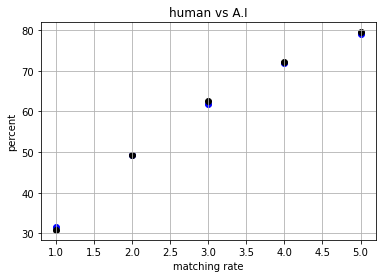

In [18]:
xx,yx = zip(*result_placex.items())
x3,y3 = zip(*human_predict.items())
plt.scatter(xx,yx,color='blue')
plt.scatter(x3,y3,color='black')
plt.title('human vs A.I')
plt.xlabel('matching rate')
plt.ylabel('percent')
plt.grid(True)

In [19]:
tansho_placex = calc_gain(me.calc_test_return, pred_table_placex)

  0%|          | 0/100 [00:00<?, ?it/s]

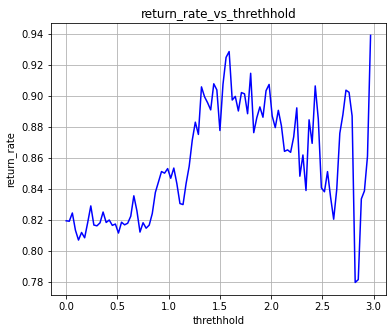

In [20]:
plt.figure(figsize=(6,5))
plt.plot(tansho_placex.index,tansho_placex['return_rate'],color='blue')
plt.title('return_rate_vs_threthhold')
plt.xlabel('threthhold')
plt.ylabel('return_rate')
plt.grid(True)

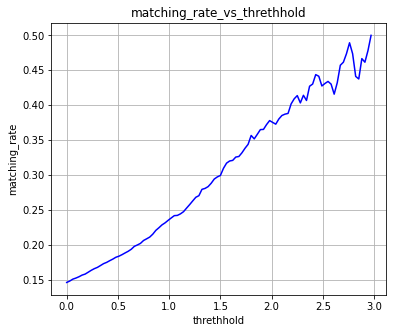

In [21]:
plt.figure(figsize=(6,5))
plt.plot(tansho_placex.index,tansho_placex['n_hits']/tansho_placex['n_bets'],color='blue')
plt.title('matching_rate_vs_threthhold')
plt.xlabel('threthhold')
plt.ylabel('matching_rate')
plt.grid(True)

/var/folders/qg/9jmsbkrn6l91tb7575myr7l00000gn/T/ipykernel_51544/2167427382.py:4: RuntimeWarning: invalid value encountered in log
  residual = np.log(y) - (np.log(a) + b * x)
/var/folders/qg/9jmsbkrn6l91tb7575myr7l00000gn/T/ipykernel_51544/2167427382.py:4: RuntimeWarning: invalid value encountered in log
  residual = np.log(y) - (np.log(a) + b * x)


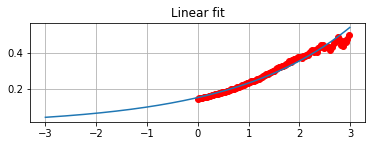

In [22]:
def fit_exp_linear(parameter, x, y):
    a = parameter[0]
    b = parameter[1]
    residual = np.log(y) - (np.log(a) + b * x)
    return residual

def exp_string(a, b):
    return "$y = %0.4f e^{ %0.4f x}$" % (a, b)

if __name__ == "__main__":

    x = tansho_placex.index
    y = tansho_placex['n_hits']/tansho_placex['n_bets']
    
    parameter0 = [1, 1]

    param = sp.optimize.leastsq(fit_exp_linear, parameter0, args=(x, y))

    model_func = lambda a, b, x: a * np.exp(b * x)

    fig = plt.figure()

    ax2 = fig.add_subplot(2, 1, 2)

    ax2.plot(x, y, "ro")

    xx = np.arange(-3, 3, 0.01)

    ax2.plot(xx, model_func(param[0][0], param[0][1], xx))
    ax2.set_title("Linear fit")
    ax2.grid(True)
    plt.show()

In [23]:
del X_test_placex,X_train_placex,X_valid_placex

# Shutuba_data

In [24]:
No = '11'
race1 = '中山'
race2 = '中京'
race3 = '小倉'

raceid1 = '2023060107'
raceid2 = '2023070107'
raceid3 = '2023100103'

race_id1 = [raceid1+'{}'.format(str(i).zfill(2)) for i in range(6,13,1)]
race_id2 = [raceid2+'{}'.format(str(i).zfill(2)) for i in range(6,13,1)]
race_id3 = [raceid3+'{}'.format(str(i).zfill(2)) for i in range(6,13,1)]

race_id_list = race_id1 + race_id2 + race_id3
#race_id_list.remove('202106050909')
st = ShutubaTable.scrape(race_id_list)

  0%|          | 0/21 [00:00<?, ?it/s]

/var/folders/qg/9jmsbkrn6l91tb7575myr7l00000gn/T/ipykernel_51544/1326784534.py:203: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(df)
/var/folders/qg/9jmsbkrn6l91tb7575myr7l00000gn/T/ipykernel_51544/1326784534.py:203: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(df)
/var/folders/qg/9jmsbkrn6l91tb7575myr7l00000gn/T/ipykernel_51544/1326784534.py:203: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(df)
/var/folders/qg/9jmsbkrn6l91tb7575myr7l00000gn/T/ipykernel_51544/1326784534.py:203: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(df)
/var/folders/qg/9jmsbkrn6l91tb75

In [25]:
st.data = st.data[st.data['horse_id'] != '2020106919']
#st.data = st.data[st.data['trainer_id'] != '01195']
#st.data = st.data[st.data['jockey_id'] != '05620']

st.preprocessing(weight=True)
st.merge_horse_results(hr,n_samples_list=[1,2,3,4])
st.merge_jockey_results(jr,n_samples_list=[60])
st.merge_trainer_results(tr,n_samples_list=[60])
st.data_p.dropna(subset=['h_rank/heads_1R'],inplace=True)
st.process_categorical(r.data_p,st=True)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [26]:
df_vs = pd.DataFrame()
df_vs = pd.DataFrame(st.data_c[f_params].add_prefix('vs_')).groupby(level=0).transform(standard_scaler)
st.data_c = pd.concat([st.data_c,df_vs],axis=1)
st.data_c = st.data_c.fillna(r.data_c.median())
pred_table_stx = st.data_c
predx_1 = pd.DataFrame(network_placex_1.predict(transform_input2(pred_table_stx)),index=pred_table_stx.index).groupby(level=0).transform(standard_scaler)
predx_2 = pd.DataFrame(network_placex_2.predict(transform_input2(pred_table_stx)),index=pred_table_stx.index).groupby(level=0).transform(standard_scaler)
pred_table_stx['pred_nn_art'] = (predx_1*2+predx_2)/3
pred_table_stx['ratio'] = param[0][0] * np.exp(param[0][1] * pred_table_stx['pred_nn_art'])

/var/folders/qg/9jmsbkrn6l91tb7575myr7l00000gn/T/ipykernel_51544/3333384553.py:4: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  st.data_c = st.data_c.fillna(r.data_c.median())
/var/folders/qg/9jmsbkrn6l91tb7575myr7l00000gn/T/ipykernel_51544/1326784534.py:1476: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df_x = df_x.fillna(df_x.median())
/var/folders/qg/9jmsbkrn6l91tb7575myr7l00000gn/T/ipykernel_51544/1326784534.py:1476: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df_x = df_x.fillna(df_x.median())
/var/folders/qg/9jmsbkrn6l91tb7575myr7l00000gn/T/ipykernel_51544/3333384553.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many t

## 中山

In [30]:
R = '11'
tb = show_ai_index_table(raceid1, R, save=True)
tb.style.background_gradient(cmap='Wistia')

  0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/qg/9jmsbkrn6l91tb7575myr7l00000gn/T/ipykernel_51544/1326784534.py:1437: DeprecationWarning: find_elements_by_* commands are deprecated. Please use find_elements() instead
  elements = driver.find_elements_by_class_name('HorseList')
/Users/hjm.f/miniforge3/envs/test_env/lib/python3.9/site-packages/selenium/webdriver/remote/webelement.py:359: UserWarning: find_elements_by_* commands are deprecated. Please use find_elements() instead
  warnings.warn("find_elements_by_* commands are deprecated. Please use find_elements() instead")
/Users/hjm.f/miniforge3/envs/test_env/lib/python3.9/site-packages/selenium/webdriver/remote/webelement.py:341: UserWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  warnings.warn("find_element_by_* commands are deprecated. Please use find_element() instead")
/var/folders/qg/9jmsbkrn6l91tb7575myr7l00000gn/T/ipykernel_51544/1326784534.py:1449: FutureWarning: The frame.append method is deprecated and will be removed

TypeError: Index(...) must be called with a collection of some kind, '202306010711' was passed

In [28]:
df = pd.read_pickle('ai_index_table_202306010711')
df

,date,number,weight,++weight,weather,ground,ozz,popularity,ratio
0,2023-01-21,1,520.0,0.0,晴,稍重,149.0,12,0.099679
1,2023-01-21,2,500.0,0.0,晴,稍重,77.5,10,0.119720
2,2023-01-21,3,492.0,0.0,晴,稍重,15.4,4,0.201468
3,2023-01-21,4,472.0,6.0,晴,稍重,23.6,7,0.150172
4,2023-01-21,5,526.0,10.0,晴,稍重,27.4,8,0.130261
5,2023-01-21,6,444.0,-10.0,晴,稍重,6.2,2,0.232385
6,2023-01-21,7,498.0,6.0,晴,稍重,170.4,14,0.120003
7,2023-01-21,8,466.0,6.0,晴,稍重,8.0,3,0.185895
8,2023-01-21,9,502.0,4.0,晴,稍重,1.5,1,0.479053
9,2023-01-21,10,482.0,2.0,晴,稍重,20.1,5,0.153373


## 中京

In [35]:
R ='09'
tb = show_ai_index_table(raceid2, R, save=True)
tb.style.background_gradient(cmap='Wistia')

  0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/qg/9jmsbkrn6l91tb7575myr7l00000gn/T/ipykernel_45978/1326784534.py:1437: DeprecationWarning: find_elements_by_* commands are deprecated. Please use find_elements() instead
  elements = driver.find_elements_by_class_name('HorseList')
/Users/hjm.f/miniforge3/envs/test_env/lib/python3.9/site-packages/selenium/webdriver/remote/webelement.py:359: UserWarning: find_elements_by_* commands are deprecated. Please use find_elements() instead
  warnings.warn("find_elements_by_* commands are deprecated. Please use find_elements() instead")
/Users/hjm.f/miniforge3/envs/test_env/lib/python3.9/site-packages/selenium/webdriver/remote/webelement.py:341: UserWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  warnings.warn("find_element_by_* commands are deprecated. Please use find_element() instead")
/var/folders/qg/9jmsbkrn6l91tb7575myr7l00000gn/T/ipykernel_45978/1326784534.py:1449: FutureWarning: The frame.append method is deprecated and will be removed

中山11 ダート 1800m


,number,waku_winrate,horse,days,interval,++weight,vs_runtime_3R,vs_spurt_3R,vs_rush_3R,vs_diff_3R,1st_corner_3R,vs_style_winrate,jockey,j_diff_60R,popularity,ozz,pred_nn_art,ratio,Ex
6,7,0.204706,シダー,3.887671,3.332205,4.000000,0.967730,-0.681127,-0.311395,0.043146,4.666667,1.252664,松山,0.111378,3,8.500000,1.623532,5.070969,43.103237
8,9,0.215556,ドライゼ,4.013699,3.332205,0.000000,0.193546,0.021228,-0.353318,0.515344,7.333333,-0.001619,川田,0.729033,2,5.300000,1.500341,4.483218,23.761054
1,2,0.226488,カラフルキューブ,3.942466,4.127134,4.000000,0.967730,0.297126,0.424504,1.171195,10.333333,-0.397429,吉田隼,0.327194,4,11.800000,1.285579,3.616760,42.677774
3,4,0.252453,ステイブルアスク,4.780822,4.248495,8.000000,1.793526,-0.165612,0.527632,0.332414,11.666667,-0.397429,坂井,0.156396,1,1.800000,1.278529,3.591352,6.464433
7,8,0.204706,アーテルアストレア,3.956164,3.891820,2.000000,0.038709,1.665356,1.301312,1.045428,12.000000,-1.739039,菱田,-0.018223,5,15.400000,0.654188,1.923579,29.623120
2,3,0.252453,ルーチェット,5.000000,4.418841,-12.000000,-0.529026,-0.254067,0.175075,0.494914,6.333333,-0.001619,荻野極,-0.685069,10,41.400000,0.171176,1.186700,49.129375
15,16,0.220797,アイリッシュムーン,4.698630,4.248495,0.000000,0.606444,0.887069,0.198446,0.551884,3.666667,1.252664,鮫島駿,0.044983,8,27.900000,0.033238,1.033797,28.842937
4,5,0.207358,ブルーカルセドニー,4.794521,2.772589,-8.000000,-0.374189,-0.006606,0.245790,0.415752,5.000000,1.252664,Ｍデムーロ,0.443564,12,60.200000,-0.066575,0.935593,56.322674
5,6,0.207358,ランスオブアース,4.843836,3.713572,-4.000000,0.090321,-1.232519,-0.585098,-0.079472,4.333333,1.252664,武豊,0.205322,6,19.000000,-0.195568,0.822367,15.624981
14,15,0.220797,クレデンザ,5.761644,4.143135,6.000000,0.503220,0.612688,0.428866,-0.112023,11.000000,-0.397429,岩田康,0.066685,7,20.400000,-0.331059,0.718162,14.650515


## 中京

In [36]:
R ='09'
tb = show_ai_index_table(raceid3, R, save=True)
tb.style.background_gradient(cmap='Wistia')

  0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/qg/9jmsbkrn6l91tb7575myr7l00000gn/T/ipykernel_45978/1326784534.py:1437: DeprecationWarning: find_elements_by_* commands are deprecated. Please use find_elements() instead
  elements = driver.find_elements_by_class_name('HorseList')
/Users/hjm.f/miniforge3/envs/test_env/lib/python3.9/site-packages/selenium/webdriver/remote/webelement.py:359: UserWarning: find_elements_by_* commands are deprecated. Please use find_elements() instead
  warnings.warn("find_elements_by_* commands are deprecated. Please use find_elements() instead")
/Users/hjm.f/miniforge3/envs/test_env/lib/python3.9/site-packages/selenium/webdriver/remote/webelement.py:341: UserWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  warnings.warn("find_element_by_* commands are deprecated. Please use find_element() instead")
/var/folders/qg/9jmsbkrn6l91tb7575myr7l00000gn/T/ipykernel_45978/1326784534.py:1449: FutureWarning: The frame.append method is deprecated and will be removed

中山11 芝 1200m


,number,waku_winrate,horse,days,interval,++weight,vs_runtime_3R,vs_spurt_3R,vs_rush_3R,vs_diff_3R,1st_corner_3R,vs_style_winrate,jockey,j_diff_60R,popularity,ozz,pred_nn_art,ratio,Ex
6,7,0.206118,ルーフ,2.843836,4.510860,-6.000000,0.323334,1.564949,1.717966,1.104664,5.000000,-0.102865,藤岡康,0.375590,2,3.500000,1.746427,5.734078,20.069273
1,2,0.177188,ダンシングニードル,2.936986,3.332205,-8.000000,1.924607,0.256246,0.105380,0.481281,1.000000,1.240625,団野,-0.051925,1,2.000000,1.330973,3.784722,7.569445
2,3,0.186760,オーサムサンライズ,2.764384,4.343805,-6.000000,-0.970002,-0.482475,0.655729,0.751470,3.000000,-0.102865,永島,-0.090559,4,9.700000,-0.214793,0.806708,7.825070
5,6,0.197547,タマモブラックタイ,2.756164,2.484907,-10.000000,-0.908414,-0.130871,-1.516127,-0.782915,3.666667,-0.102865,角田和,-0.120886,3,7.900000,-0.269621,0.763669,6.032985
0,1,0.184581,フォルテース,2.947945,2.639057,0.000000,0.754446,-0.328088,-0.419673,1.139332,1.666667,1.240625,北村友,-0.199549,5,11.500000,-0.337024,0.713891,8.209752
3,4,0.193460,ニシノトキメキ,2.997260,3.555348,2.000000,-0.046191,-0.446303,-0.706021,-1.471534,3.333333,-0.102865,亀田,-0.127376,6,12.800000,-0.660792,0.516442,6.610459
7,8,0.179623,ブライトサイン,2.895890,3.332205,2.000000,-0.169365,1.167936,0.638613,-0.328365,8.000000,-1.966925,幸,-0.107585,7,17.400000,-0.705856,0.493686,8.590133
4,5,0.216359,アウクソー,2.967123,4.234107,-10.000000,-0.908414,-1.601394,-0.475867,-0.893932,5.666667,-0.102865,野中,-0.382361,8,34.800000,-0.889313,0.410938,14.300645


In [187]:
df = pd.read_pickle('ai_index_table_202209060611')
df

,number,weight,++weight,weather,ground,ozz,popularity,ratio
202209060611,1,464.0,0.0,晴,良,202.3,16,0.098027
202209060611,2,474.0,2.0,晴,良,3.1,1,0.253109
202209060611,3,484.0,2.0,晴,良,8.0,4,0.237447
202209060611,4,474.0,8.0,晴,良,54.0,11,0.125179
202209060611,5,478.0,6.0,晴,良,24.8,8,0.114176
202209060611,6,486.0,16.0,晴,良,405.4,17,0.093562
202209060611,7,428.0,6.0,晴,良,14.0,5,0.389534
202209060611,8,452.0,8.0,晴,良,42.6,9,0.103997
202209060611,9,460.0,0.0,晴,良,135.8,15,0.098665
202209060611,10,454.0,6.0,晴,良,127.3,14,0.102512


# practice

In [39]:
url = 'https://race.netkeiba.com/race/shutuba.html?race_id=' + '202306010706'
df = pd.read_html(url)[0]
df = df.T.reset_index(level=0,drop=True).T

html = requests.get(url)
html.encoding = 'EUC-JP'
soup = BeautifulSoup(html.text,'html.parser')

texts = soup.find('div',attrs={'class':'RaceData01'}).text
texts = re.findall(r'\w+',texts)
for text in texts:
    if 'm' in text:
        df['course_len'] = [int(re.findall(r'\d+',text)[0])] * len(df)
    if text in ['曇','晴','雨','小雨','小雪','雪']:
        df['weather'] = [text] * len(df)
    if text in ['良', '稍重', '重']:
        df['ground_state'] = [text] * len(df)
    if '不' in text:
        df['ground_state'] = ['不良'] * len(df)
    if '稍' in text:
        df['ground_state'] = ['稍重'] * len(df)
    if '芝' in text:
        df['R_type'] = ['芝'] * len(df)
    if '障' in text:
        df['R_type'] = ['障害'] * len(df)
    if 'ダ' in text:
        df['R_type'] = ['ダート'] * len(df)

df.index = ['202306010706']*len(df)
date = soup.find('dd',attrs={'class':'Active'}).text
df['date'] = df.index.str[:4] + '-'+re.findall(r'\w+',date)[0].replace('月','-').replace('日','')

In [70]:
df[df['date']=='2023-1-21']['date'] = '2023-01-21'
df
#df.to_pickle('race_card_tables.pickle')

/var/folders/qg/9jmsbkrn6l91tb7575myr7l00000gn/T/ipykernel_45978/420191559.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df['date']=='2023-1-21']['date'] = '2023-01-21'


,date,R,race_name,race_genre,race_grade,発走時刻,馬番,枠,horse_id,馬名,性齢,斤量,jockey_id,騎手,course_id,place,course_len,R_type
202310010305,2023-1-21,5R,4歳以上障害OP,障害４歳以上,オープン,12:10,1,1,2016104252,ニューツーリズム,セ7,62.0,01123,小野寺,10012860,小倉,2860,芝
202310010305,2023-1-21,5R,4歳以上障害OP,障害４歳以上,オープン,12:10,2,2,2018100905,アームストロング,牡5,60.0,01113,草野,10012860,小倉,2860,芝
202310010305,2023-1-21,5R,4歳以上障害OP,障害４歳以上,オープン,12:10,3,3,2015104675,アンブロジオ,セ8,60.0,01059,石神,10012860,小倉,2860,芝
202310010305,2023-1-21,5R,4歳以上障害OP,障害４歳以上,オープン,12:10,4,4,2019101021,タマモワカムシャ,セ4,57.0,01196,小牧加,10012860,小倉,2860,芝
202310010305,2023-1-21,5R,4歳以上障害OP,障害４歳以上,オープン,12:10,5,5,2014106286,デストロイ,セ9,60.0,01068,蓑島,10012860,小倉,2860,芝
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202310010306,2023-1-21,6R,3歳未勝利,サラ系３歳,未勝利,12:45,11,6,2020106484,ミルレーヴ,牝3,50.0,01187,永島,10011800,小倉,1800,芝
202310010306,2023-1-21,6R,3歳未勝利,サラ系３歳,未勝利,12:45,12,7,2020105646,アルアマル,牝3,54.0,01158,野中,10011800,小倉,1800,芝
202310010306,2023-1-21,6R,3歳未勝利,サラ系３歳,未勝利,12:45,13,7,2020104902,ハクサンビーナス,牝3,51.0,01193,今村,10011800,小倉,1800,芝
202310010306,2023-1-21,6R,3歳未勝利,サラ系３歳,未勝利,12:45,14,8,2020100425,コスモアリス,牝3,53.0,01186,角田和,10011800,小倉,1800,芝


In [72]:
df.index.nunique()

72

In [87]:
df = pd.read_pickle('race_card_tables.pickle')
df['date'] = df['date'].map(lambda x:x.date().strftime('%Y-%m-%d'))

In [88]:
df['date'].unique()

array(['2023-01-22', '2023-01-21'], dtype=object)

In [89]:
df = pd.read_pickle('race_card_tables.pickle')
df

,date,R,race_name,race_genre,race_grade,発走時刻,馬番,枠,horse_id,馬名,性齢,斤量,jockey_id,騎手,course_id,place,course_len,R_type
202306010710,2023-01-21,10R,東雲賞,サラ系４歳以上,２勝クラス,15:10,1,1,2019100861,グランドライン,牡4,56.0,01122,三浦,06011800,中山,1800,芝
202306010710,2023-01-21,10R,東雲賞,サラ系４歳以上,２勝クラス,15:10,2,2,2015105451,ブラックデビル,セ8,54.0,01181,秋山稔,06011800,中山,1800,芝
202306010710,2023-01-21,10R,東雲賞,サラ系４歳以上,２勝クラス,15:10,3,3,2016104665,ミトロジー,セ7,56.0,05621,バシュロ,06011800,中山,1800,芝
202306010710,2023-01-21,10R,東雲賞,サラ系４歳以上,２勝クラス,15:10,4,4,2016106395,ゲバラ,牡7,56.0,01179,菅原明,06011800,中山,1800,芝
202306010710,2023-01-21,10R,東雲賞,サラ系４歳以上,２勝クラス,15:10,5,5,2017104478,ヒューマンコメディ,牝6,54.0,00641,柴田善,06011800,中山,1800,芝
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202310010406,2023-01-22,6R,3歳未勝利,サラ系３歳,未勝利,12:40,14,7,2020103775,サトノラピス,牝3,51.0,01193,今村,10011200,小倉,1200,芝
202310010406,2023-01-22,6R,3歳未勝利,サラ系３歳,未勝利,12:40,15,7,2020106537,ウィルオブラガー,牡3,53.0,01194,大久保,10011200,小倉,1200,芝
202310010406,2023-01-22,6R,3歳未勝利,サラ系３歳,未勝利,12:40,16,8,2020100891,ヨドノルーキー,牡3,56.0,01093,藤岡佑,10011200,小倉,1200,芝
202310010406,2023-01-22,6R,3歳未勝利,サラ系３歳,未勝利,12:40,17,8,2020101492,シンリンゲンカイ,牝3,53.0,01186,角田和,10011200,小倉,1200,芝
